# Import Libraries

In [106]:
import os
import random
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
import shap
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import optuna
import tensorflow_decision_forests as tfdf
import ydf
import pickle

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Global Variables

In [2]:
seed = 20

os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

tf.keras.utils.set_random_seed(seed)
tf.config.experimental.enable_op_determinism()

In [3]:
TRAIN_DIR = '/kaggle/input/dataquest-2025/training_dataset.csv' # change to local directory if needed
VAL_DIR = '/kaggle/input/dataquest-2025/validation_set.csv' # change to local directory if needed

train = pd.read_csv(TRAIN_DIR)
validation = pd.read_csv(VAL_DIR)

customer_number = validation['customer_number']

train = train.drop('customer_number', axis=1)
validation = validation.drop('customer_number', axis=1)

X = train.copy()
y = train['berlangganan_deposito']

# Dataset Understanding

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22916 entries, 0 to 22915
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   usia                          22916 non-null  int64  
 1   pekerjaan                     22916 non-null  object 
 2   status_perkawinan             22916 non-null  object 
 3   pendidikan                    22916 non-null  object 
 4   gagal_bayar_sebelumnya        22916 non-null  object 
 5   pinjaman_rumah                22916 non-null  object 
 6   pinjaman_pribadi              22916 non-null  object 
 7   jenis_kontak                  22916 non-null  object 
 8   bulan_kontak_terakhir         22916 non-null  object 
 9   hari_kontak_terakhir          22916 non-null  object 
 10  jumlah_kontak_kampanye_ini    22916 non-null  int64  
 11  hari_sejak_kontak_sebelumnya  22916 non-null  int64  
 12  jumlah_kontak_sebelumnya      22916 non-null  int64  
 13  h

In [6]:
validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5729 entries, 0 to 5728
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   usia                          5729 non-null   int64  
 1   pekerjaan                     5729 non-null   object 
 2   status_perkawinan             5729 non-null   object 
 3   pendidikan                    5729 non-null   object 
 4   gagal_bayar_sebelumnya        5729 non-null   object 
 5   pinjaman_rumah                5729 non-null   object 
 6   pinjaman_pribadi              5729 non-null   object 
 7   jenis_kontak                  5729 non-null   object 
 8   bulan_kontak_terakhir         5729 non-null   object 
 9   hari_kontak_terakhir          5729 non-null   object 
 10  jumlah_kontak_kampanye_ini    5729 non-null   int64  
 11  hari_sejak_kontak_sebelumnya  5729 non-null   int64  
 12  jumlah_kontak_sebelumnya      5729 non-null   int64  
 13  has

In [7]:
train.head()

,usia,pekerjaan,status_perkawinan,pendidikan,gagal_bayar_sebelumnya,pinjaman_rumah,pinjaman_pribadi,jenis_kontak,bulan_kontak_terakhir,hari_kontak_terakhir,jumlah_kontak_kampanye_ini,hari_sejak_kontak_sebelumnya,jumlah_kontak_sebelumnya,hasil_kampanye_sebelumnya,tingkat_variasi_pekerjaan,indeks_harga_konsumen,indeks_kepercayaan_konsumen,suku_bunga_euribor_3bln,jumlah_pekerja,pulau,berlangganan_deposito
0,63,sosial media specialis,menikah,Pendidikan Tinggi,no,yes,no,cellular,jul,fri,2,999,0,nonexistent,-1.7,94.215,-40.3,0.885,4991.6,Papua,1
1,43,teknisi,menikah,Pendidikan Tinggi,no,yes,no,cellular,nov,fri,2,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,Sulawesi,0
2,29,sosial media specialis,lajang,Pendidikan Tinggi,no,yes,yes,cellular,jul,thu,1,999,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1,Papua,0
3,40,pekerja kasar,menikah,SMA,no,no,no,telephone,may,wed,2,999,0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,Sumatera,1
4,40,sosial media specialis,lajang,Pendidikan Tinggi,no,no,no,cellular,aug,wed,3,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,Bali,0


In [8]:
validation.head()

,usia,pekerjaan,status_perkawinan,pendidikan,gagal_bayar_sebelumnya,pinjaman_rumah,pinjaman_pribadi,jenis_kontak,bulan_kontak_terakhir,hari_kontak_terakhir,jumlah_kontak_kampanye_ini,hari_sejak_kontak_sebelumnya,jumlah_kontak_sebelumnya,hasil_kampanye_sebelumnya,tingkat_variasi_pekerjaan,indeks_harga_konsumen,indeks_kepercayaan_konsumen,suku_bunga_euribor_3bln,jumlah_pekerja,pulau
0,35,penyedia jasa,menikah,SMA,no,yes,yes,cellular,jul,mon,1,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,Jawa
1,52,teknisi,lajang,Diploma,unknown,no,no,telephone,may,thu,4,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,Papua
2,37,pekerja kasar,menikah,SMP,unknown,yes,no,telephone,may,wed,3,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,Bali
3,51,pengangguran,menikah,Diploma,no,no,no,telephone,may,tue,3,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,Sumatera
4,45,teknisi,cerai,SMA,no,yes,no,cellular,may,thu,1,999,1,failure,-1.8,92.893,-46.2,1.327,5099.1,Sumatera


# EDA

In [9]:
numerical = train.select_dtypes(exclude='object').columns.tolist()
categorical = train.select_dtypes(include='object').columns.tolist()

## Categorical Unique Values & Counts

In [10]:
for col in categorical:
    print(f"=== {col} ===")
    print(train[col].unique())
    print()

=== pekerjaan ===
['sosial media specialis' 'teknisi' 'pekerja kasar' 'manajer'
 'asisten rumah tangga' 'mahasiswa' 'penyedia jasa' 'pemilik bisnis'
 'entrepreneur' 'pengangguran' 'pensiunan' 'unknown']

=== status_perkawinan ===
['menikah' 'lajang' 'cerai' 'unknown']

=== pendidikan ===
['Pendidikan Tinggi' 'SMA' 'Tidak Tamat SD' 'SMP' 'Diploma' 'SD' 'unknown'
 'TIDAK SEKOLAH']

=== gagal_bayar_sebelumnya ===
['no' 'unknown' 'yes']

=== pinjaman_rumah ===
['yes' 'no' 'unknown']

=== pinjaman_pribadi ===
['no' 'yes' 'unknown']

=== jenis_kontak ===
['cellular' 'telephone']

=== bulan_kontak_terakhir ===
['jul' 'nov' 'may' 'aug' 'oct' 'apr' 'jun' 'sep' 'mar' 'dec']

=== hari_kontak_terakhir ===
['fri' 'thu' 'wed' 'tue' 'mon']

=== hasil_kampanye_sebelumnya ===
['nonexistent' 'failure' 'success']

=== pulau ===
['Papua' 'Sulawesi' 'Sumatera' 'Bali' 'NTT' 'Jawa' 'NTB' 'Kalimantan']



In [11]:
for col in categorical:
    print(train[col].value_counts())
    print()

pekerjaan
sosial media specialis    5755
pekerja kasar             5191
teknisi                   3709
penyedia jasa             2195
manajer                   1653
pensiunan                  968
entrepreneur               815
pemilik bisnis             784
asisten rumah tangga       578
pengangguran               561
mahasiswa                  514
unknown                    193
Name: count, dtype: int64

status_perkawinan
menikah    13858
lajang      6445
cerai       2566
unknown       47
Name: count, dtype: int64

pendidikan
Pendidikan Tinggi    6699
SMA                  5403
SMP                  3337
Diploma              2881
Tidak Tamat SD       2284
SD                   1308
unknown               992
TIDAK SEKOLAH          12
Name: count, dtype: int64

gagal_bayar_sebelumnya
no         18169
unknown     4745
yes            2
Name: count, dtype: int64

pinjaman_rumah
yes        12053
no         10284
unknown      579
Name: count, dtype: int64

pinjaman_pribadi
no         18888
yes 

## Null Values Count

In [12]:
train.isna().sum()

usia                            0
pekerjaan                       0
status_perkawinan               0
pendidikan                      0
gagal_bayar_sebelumnya          0
pinjaman_rumah                  0
pinjaman_pribadi                0
jenis_kontak                    0
bulan_kontak_terakhir           0
hari_kontak_terakhir            0
jumlah_kontak_kampanye_ini      0
hari_sejak_kontak_sebelumnya    0
jumlah_kontak_sebelumnya        0
hasil_kampanye_sebelumnya       0
tingkat_variasi_pekerjaan       0
indeks_harga_konsumen           0
indeks_kepercayaan_konsumen     0
suku_bunga_euribor_3bln         0
jumlah_pekerja                  0
pulau                           0
berlangganan_deposito           0
dtype: int64

In [13]:
validation.isna().sum()

usia                            0
pekerjaan                       0
status_perkawinan               0
pendidikan                      0
gagal_bayar_sebelumnya          0
pinjaman_rumah                  0
pinjaman_pribadi                0
jenis_kontak                    0
bulan_kontak_terakhir           0
hari_kontak_terakhir            0
jumlah_kontak_kampanye_ini      0
hari_sejak_kontak_sebelumnya    0
jumlah_kontak_sebelumnya        0
hasil_kampanye_sebelumnya       0
tingkat_variasi_pekerjaan       0
indeks_harga_konsumen           0
indeks_kepercayaan_konsumen     0
suku_bunga_euribor_3bln         0
jumlah_pekerja                  0
pulau                           0
dtype: int64

## Numerical Describe

In [14]:
train.describe()

,usia,jumlah_kontak_kampanye_ini,hari_sejak_kontak_sebelumnya,jumlah_kontak_sebelumnya,tingkat_variasi_pekerjaan,indeks_harga_konsumen,indeks_kepercayaan_konsumen,suku_bunga_euribor_3bln,jumlah_pekerja,berlangganan_deposito
count,22916.000000,22916.000000,22916.000000,22916.000000,22916.000000,22916.000000,22916.000000,22916.000000,22916.000000,22916.000000
mean,40.016233,2.561878,962.210377,0.170143,0.077915,93.576541,-40.485717,3.617890,5166.773124,0.114069
std,10.438059,2.794178,187.566774,0.490611,1.576176,0.580586,4.641091,1.737591,72.479698,0.317902
min,17.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.000000,2.000000,999.000000,0.000000,1.100000,93.876000,-41.800000,4.857000,5191.000000,0.000000
75%,47.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.000000,42.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


## Violin Plot Numerical

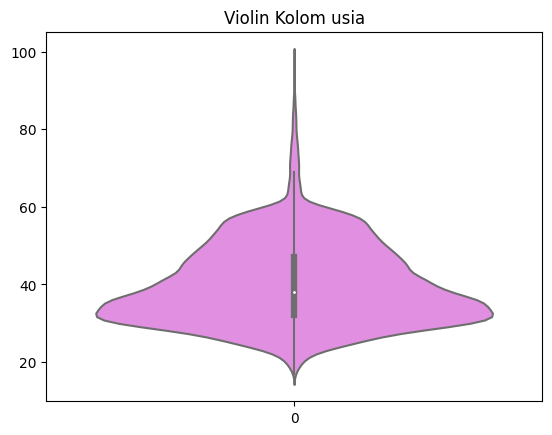

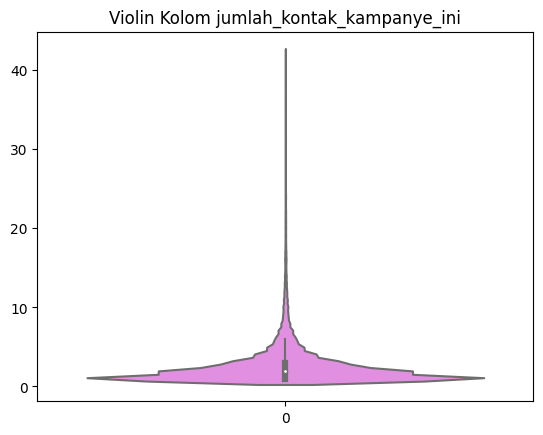

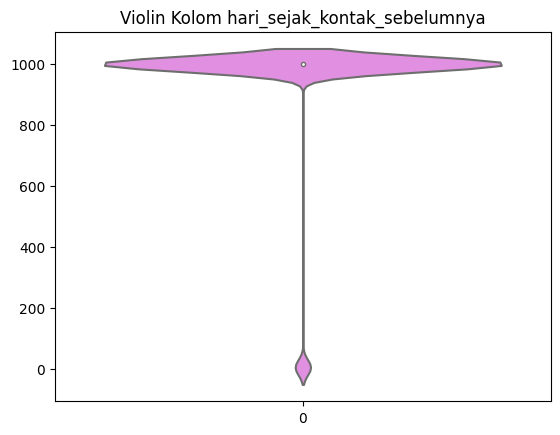

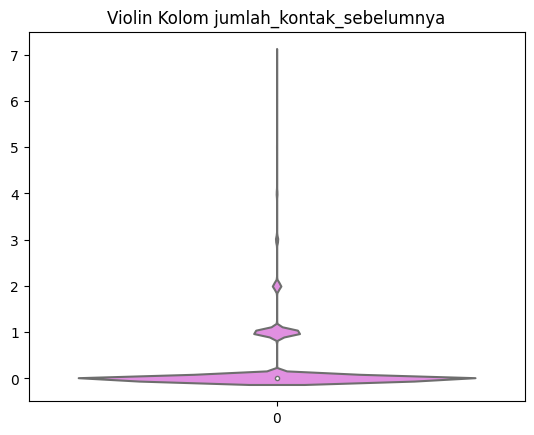

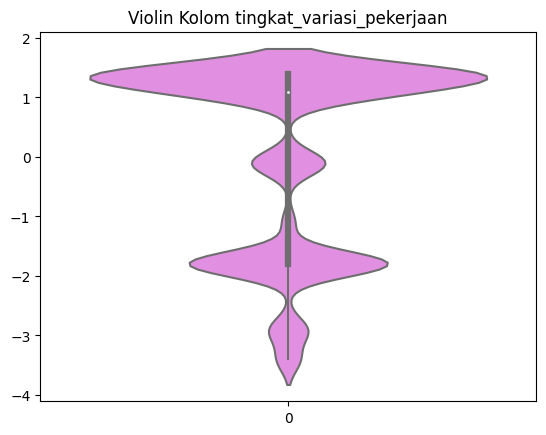

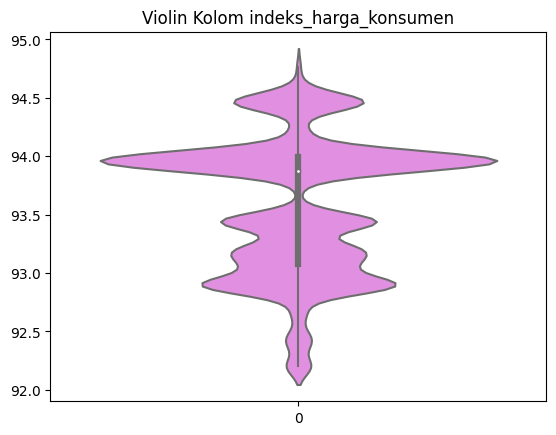

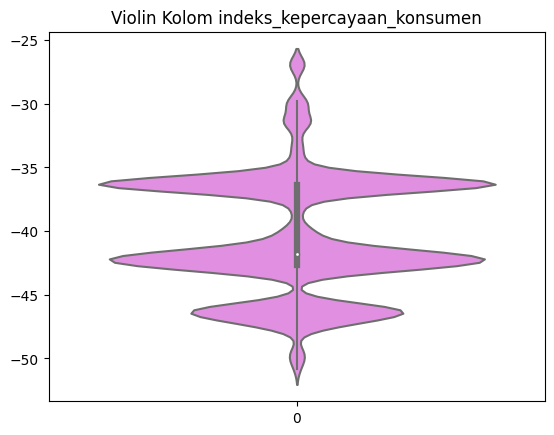

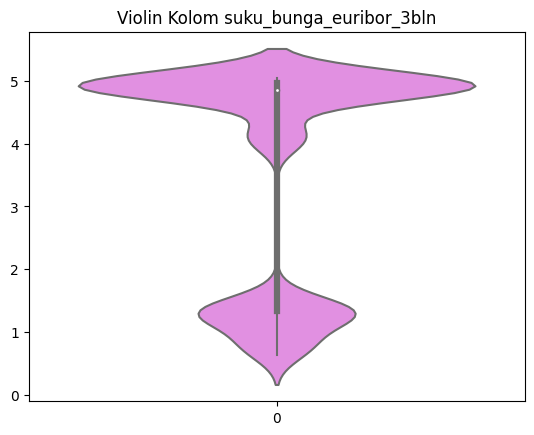

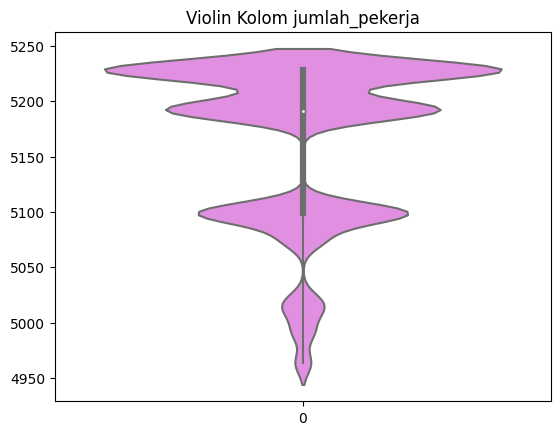

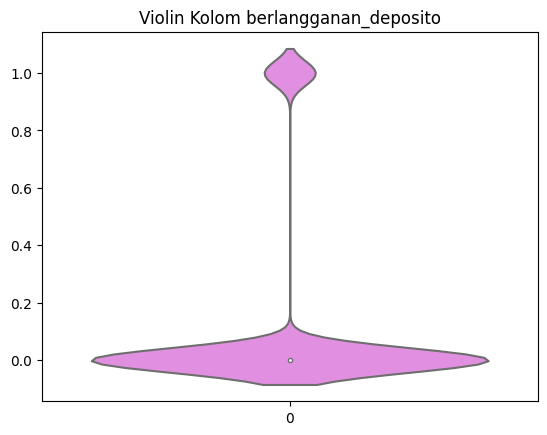

In [15]:
for col in numerical:
    sns.violinplot(train[col], color="violet")
    plt.title(f"Violin Kolom {col}")
    plt.show()

## Box Plot Numerical

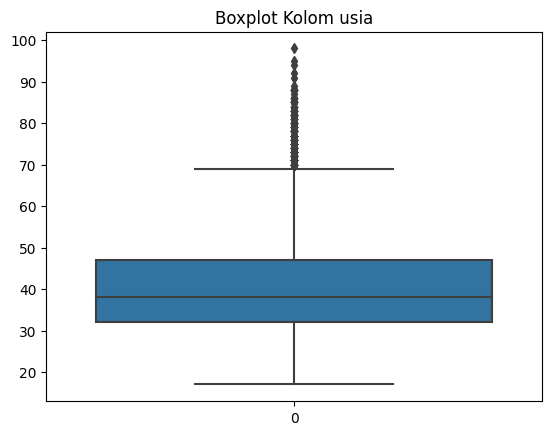

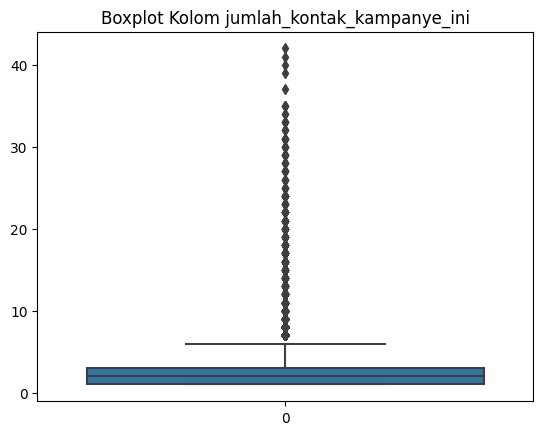

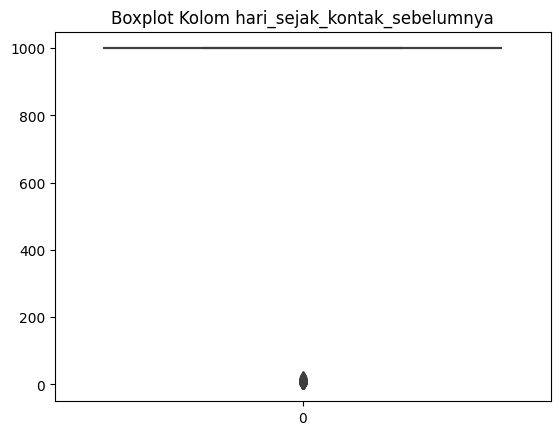

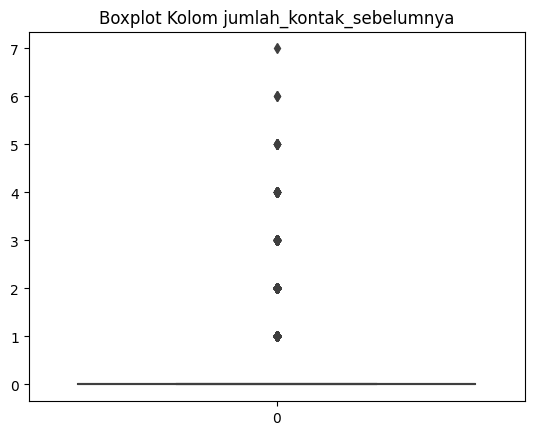

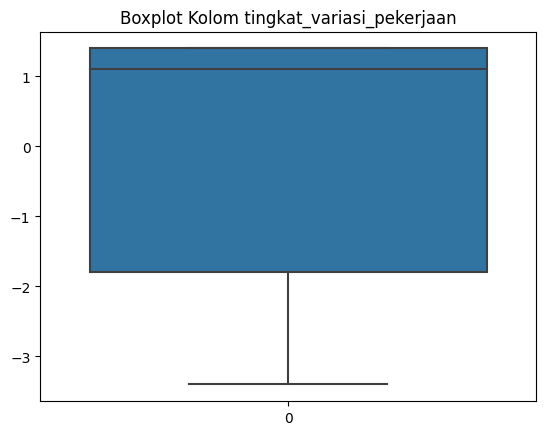

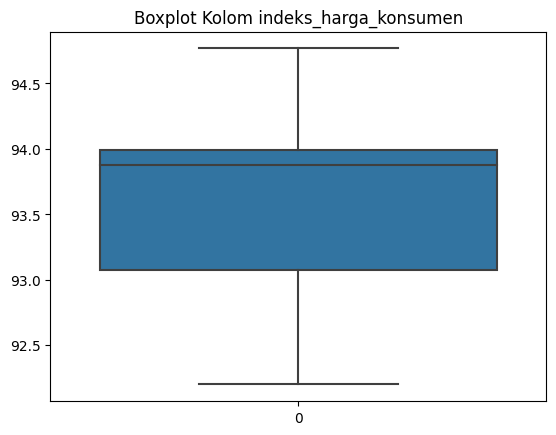

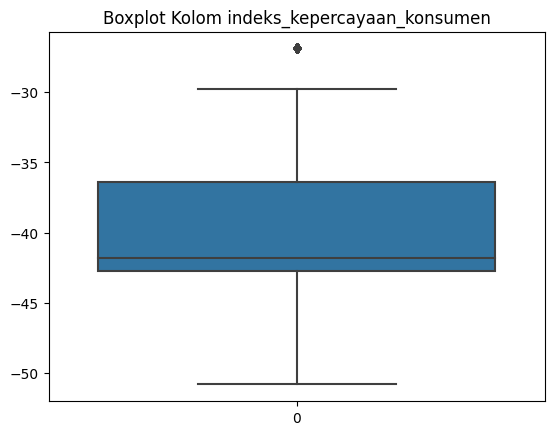

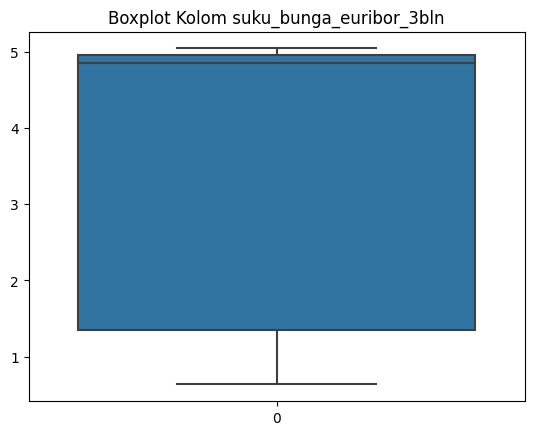

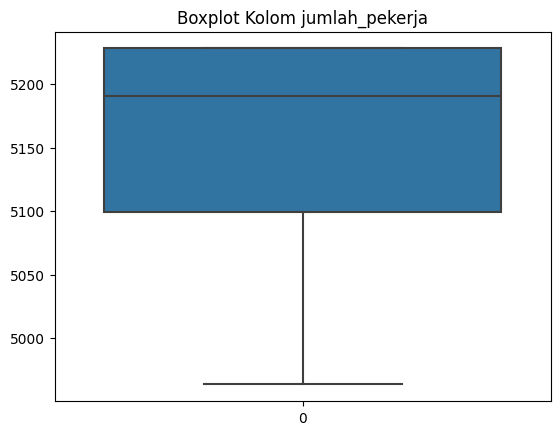

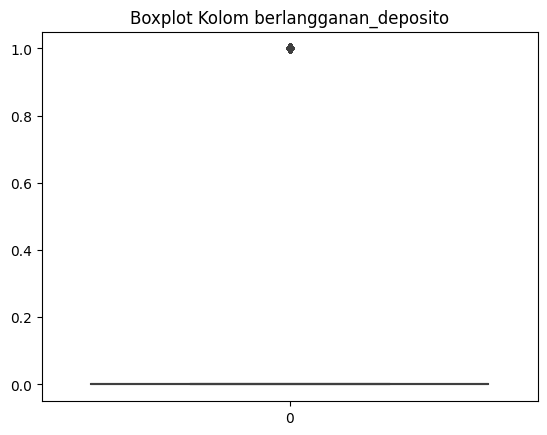

In [16]:
for col in numerical:
    sns.boxplot(train[col])
    plt.title(f"Boxplot Kolom {col}")
    plt.show()

## Skewness Analysis

In [17]:
for col in numerical:
    skew_value = skew(train[col].dropna())
    if abs(skew_value) < 0.5:
        print(f"{col}\nMEAN, {skew_value}")
    else:
        print(f"{col}\nMEDIAN, {skew_value}")
    print()

usia
MEDIAN, 0.7709463571558112

jumlah_kontak_kampanye_ini
MEDIAN, 4.808596581449448

hari_sejak_kontak_sebelumnya
MEDIAN, -4.902183714736475

jumlah_kontak_sebelumnya
MEDIAN, 3.848838872026453

tingkat_variasi_pekerjaan
MEDIAN, -0.7245749376954805

indeks_harga_konsumen
MEAN, -0.2500702287978153

indeks_kepercayaan_konsumen
MEAN, 0.31438996241687506

suku_bunga_euribor_3bln
MEDIAN, -0.705494913462288

jumlah_pekerja
MEDIAN, -1.0401340271336301

berlangganan_deposito
MEDIAN, 2.4280438526879538



## Numerical Heatmap

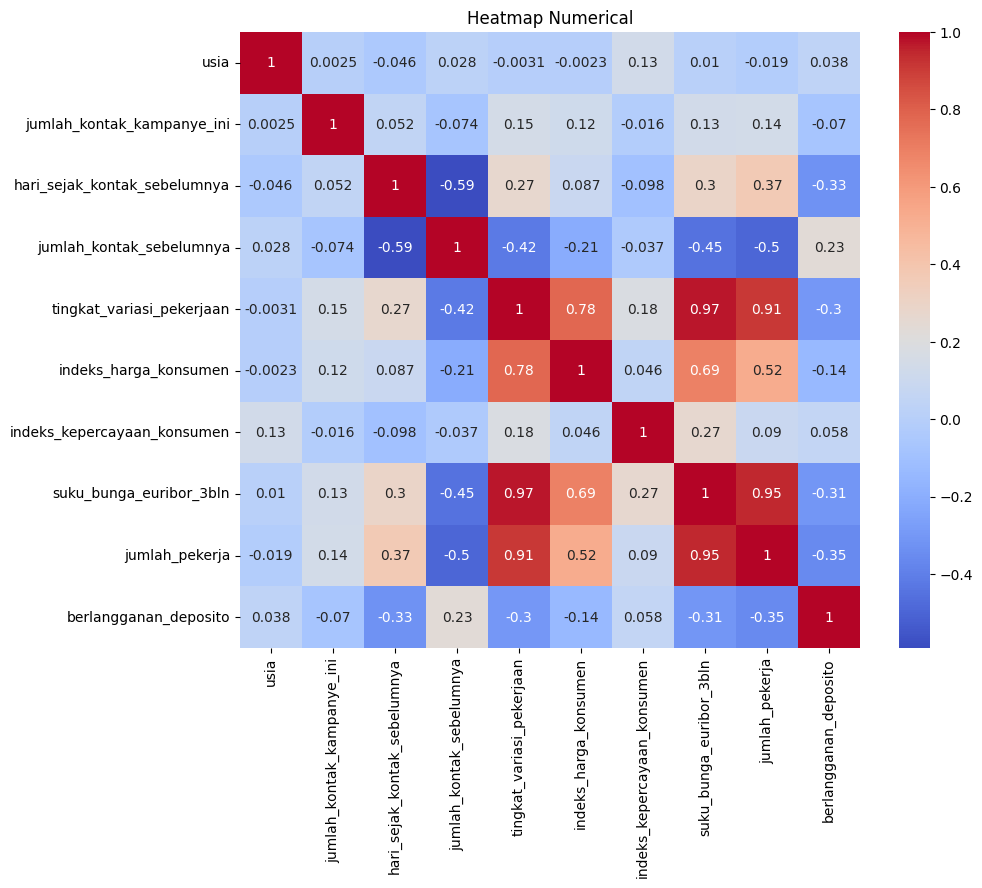

In [18]:
numeric_corr = train.corr(numeric_only=True)

plt.figure(figsize=(10,8))
sns.heatmap(numeric_corr, annot=True, cmap='coolwarm')
plt.title("Heatmap Numerical")
plt.show()

## Categorical Heatmap

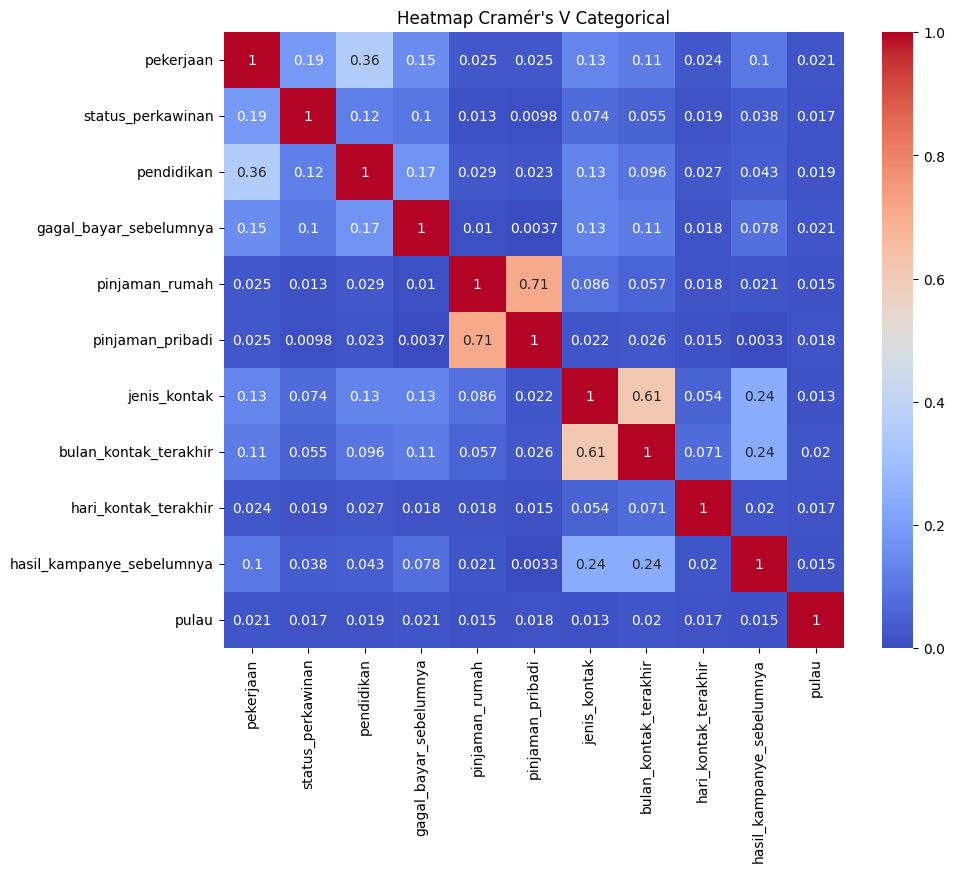

In [19]:
categorical_cramer_matrix = pd.DataFrame(np.zeros((len(categorical), len(categorical))), columns=categorical, index=categorical)

for i in range(len(categorical)):
    col_i = categorical[i]
    for j in range(i + 1, len(categorical)):
        col_j = categorical[j]
        table = pd.crosstab(train[col_i], train[col_j])
        assoc_strength = contingency.association(table, method="cramer")
        
        categorical_cramer_matrix.loc[col_i, col_j] = assoc_strength
        categorical_cramer_matrix.loc[col_j, col_i] = assoc_strength

categorical_cramer_matrix = categorical_cramer_matrix.replace(0, 1)
plt.figure(figsize=(10, 8))
sns.heatmap(categorical_cramer_matrix, annot=True, cmap='coolwarm', cbar=True, vmin=0, vmax=1)
plt.title("Heatmap Cramér's V Categorical")
plt.show()

## Target Value Counts

In [20]:
train['berlangganan_deposito'].value_counts()

berlangganan_deposito
0    20302
1     2614
Name: count, dtype: int64

# Preprocessing #1

## Train Test Split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=.2, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((18332, 21), (4584, 21), (18332,), (4584,))

## Feature Engineering
- UNCOMMENT AGG METHOD LINE TO INCLUDE THE AGG INTO GROUP BY
- UNCOMMENT MERGE LINE TO MERGE THE AGGREGATION INTO TRAIN AND VALIDATION SET

### Grouping "Identitas Nasabah" Agregasi "Makroekonomi"

#### Grouping "Bulan Kontak Terakhir" & "Hari Kontak Terakhir" Agregasi "Tingkat Variasi Pekerjaan, Suku Bunga Euribor 3 Bulan, Jumlah Pekerja"
- Kolom Agregasi dipilih KARENA mereka terpengaruh oleh WAKTU
- Prioritas **TINGGI** (Bisa Dipake : SEMUA)
- Meskipun grouping ini ditakutkan misleading karena harinya tidak dispesifikin minggu ke berapa, bisa jadi selasa disini bukan setelah senin karena selasanya ternyata selasa minggu ke 1 sedangkan seninnya senin minggu ke 2

#### - Menambah Agregasi MIN MAX

#### - X_train

In [22]:
bulan_hari_group = X_train.groupby(['bulan_kontak_terakhir', 'hari_kontak_terakhir']).agg(
    mean_bulan_hari_tingkat_variasi_pekerjaan = ('tingkat_variasi_pekerjaan','mean'),
    std_bulan_hari_tingkat_variasi_pekerjaan = ('tingkat_variasi_pekerjaan','std'),
    min_bulan_hari_tingkat_variasi_pekerjaan = ('tingkat_variasi_pekerjaan','min'),
    max_bulan_hari_tingkat_variasi_pekerjaan = ('tingkat_variasi_pekerjaan','max'),
    mean_bulan_hari_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln','mean'),
    std_bulan_hari_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln','std'),
    min_bulan_hari_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln','min'),
    max_bulan_hari_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln','max'),
    mean_bulan_hari_jumlah_pekerja = ('jumlah_pekerja','mean'),
    std_bulan_hari_jumlah_pekerja = ('jumlah_pekerja','std'),
    min_bulan_hari_jumlah_pekerja = ('jumlah_pekerja','min'),
    max_bulan_hari_jumlah_pekerja = ('jumlah_pekerja','max'),
).reset_index()

#### Mengurutkan Bulan dan Hari, Count Hasil Kampanye Values & Melihat perbedaan value dengan bulan sebelumnya dalam persenan atau selisih mentah

#### - X_train, X_test

In [23]:
urutan_bulan = ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
urutan_hari = ['mon', 'tue', 'wed', 'thu', 'fri']

bulan_hari_group['bulan_kontak_terakhir'] = pd.Categorical(
    bulan_hari_group['bulan_kontak_terakhir'],
    categories=urutan_bulan,
    ordered=True
)

bulan_hari_group['hari_kontak_terakhir'] = pd.Categorical(
    bulan_hari_group['hari_kontak_terakhir'],
    categories=urutan_hari,
    ordered=True
)

bulan_hari_group = bulan_hari_group.sort_values(['bulan_kontak_terakhir', 'hari_kontak_terakhir']).reset_index(drop=True)

hasil_kampanye_counts = pd.crosstab(
    index=[X_train['bulan_kontak_terakhir'], X_train['hari_kontak_terakhir']],
    columns=X_train['hasil_kampanye_sebelumnya']
).rename(columns=lambda x: f'count_bulan_hari_{x}').reset_index()

bulan_hari_group = bulan_hari_group.merge(
    hasil_kampanye_counts,
    how='left',
    on=['bulan_kontak_terakhir', 'hari_kontak_terakhir']
).fillna(0)

bulan_hari_group['pct_change_bulan_hari_tingkat_variasi_pekerjaan'] = bulan_hari_group['mean_bulan_hari_tingkat_variasi_pekerjaan'].pct_change()
bulan_hari_group['pct_change_bulan_hari_suku_bunga_euribor_3bln'] = bulan_hari_group['mean_bulan_hari_suku_bunga_euribor_3bln'].pct_change()
bulan_hari_group['diff_bulan_hari_jumlah_pekerja'] = bulan_hari_group['mean_bulan_hari_jumlah_pekerja'].diff()

mean_pct_change_tingkat_variasi_pekerjaan = bulan_hari_group['pct_change_bulan_hari_tingkat_variasi_pekerjaan'].mean()
mean_pct_change_suku_bunga_euribor_3bln = bulan_hari_group['pct_change_bulan_hari_suku_bunga_euribor_3bln'].mean()
mean_diff_jumlah_pekerja = bulan_hari_group['diff_bulan_hari_jumlah_pekerja'].mean()

bulan_hari_group['pct_change_bulan_hari_tingkat_variasi_pekerjaan'] = bulan_hari_group['pct_change_bulan_hari_tingkat_variasi_pekerjaan'].fillna(mean_pct_change_tingkat_variasi_pekerjaan)
bulan_hari_group['pct_change_bulan_hari_suku_bunga_euribor_3bln'] = bulan_hari_group['pct_change_bulan_hari_suku_bunga_euribor_3bln'].fillna(mean_pct_change_suku_bunga_euribor_3bln)
bulan_hari_group['diff_bulan_hari_jumlah_pekerja'] = bulan_hari_group['diff_bulan_hari_jumlah_pekerja'].fillna(mean_diff_jumlah_pekerja)

X_train = X_train.merge(bulan_hari_group, how='left', on=['bulan_kontak_terakhir', 'hari_kontak_terakhir'])
X_test = X_test.merge(bulan_hari_group, how='left', on=['bulan_kontak_terakhir', 'hari_kontak_terakhir'])

#### - Apply to X, validation

In [24]:
bulan_hari_group = X.groupby(['bulan_kontak_terakhir', 'hari_kontak_terakhir']).agg(
    mean_bulan_hari_tingkat_variasi_pekerjaan = ('tingkat_variasi_pekerjaan','mean'),
    std_bulan_hari_tingkat_variasi_pekerjaan = ('tingkat_variasi_pekerjaan','std'),
    min_bulan_hari_tingkat_variasi_pekerjaan = ('tingkat_variasi_pekerjaan','min'),
    max_bulan_hari_tingkat_variasi_pekerjaan = ('tingkat_variasi_pekerjaan','max'),
    mean_bulan_hari_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln','mean'),
    std_bulan_hari_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln','std'),
    min_bulan_hari_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln','min'),
    max_bulan_hari_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln','max'),
    mean_bulan_hari_jumlah_pekerja = ('jumlah_pekerja','mean'),
    std_bulan_hari_jumlah_pekerja = ('jumlah_pekerja','std'),
    min_bulan_hari_jumlah_pekerja = ('jumlah_pekerja','min'),
    max_bulan_hari_jumlah_pekerja = ('jumlah_pekerja','max'),
).reset_index()

In [25]:
urutan_bulan = ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
urutan_hari = ['mon', 'tue', 'wed', 'thu', 'fri']

bulan_hari_group['bulan_kontak_terakhir'] = pd.Categorical(
    bulan_hari_group['bulan_kontak_terakhir'],
    categories=urutan_bulan,
    ordered=True
)

bulan_hari_group['hari_kontak_terakhir'] = pd.Categorical(
    bulan_hari_group['hari_kontak_terakhir'],
    categories=urutan_hari,
    ordered=True
)

bulan_hari_group = bulan_hari_group.sort_values(['bulan_kontak_terakhir', 'hari_kontak_terakhir']).reset_index(drop=True)

hasil_kampanye_counts = pd.crosstab(
    index=[X['bulan_kontak_terakhir'], X['hari_kontak_terakhir']],
    columns=X['hasil_kampanye_sebelumnya']
).rename(columns=lambda x: f'count_bulan_hari_{x}').reset_index()

bulan_hari_group = bulan_hari_group.merge(
    hasil_kampanye_counts,
    how='left',
    on=['bulan_kontak_terakhir', 'hari_kontak_terakhir']
).fillna(0)

bulan_hari_group['pct_change_bulan_hari_tingkat_variasi_pekerjaan'] = bulan_hari_group['mean_bulan_hari_tingkat_variasi_pekerjaan'].pct_change()
bulan_hari_group['pct_change_bulan_hari_suku_bunga_euribor_3bln'] = bulan_hari_group['mean_bulan_hari_suku_bunga_euribor_3bln'].pct_change()
bulan_hari_group['diff_bulan_hari_jumlah_pekerja'] = bulan_hari_group['mean_bulan_hari_jumlah_pekerja'].diff()

mean_pct_change_tingkat_variasi_pekerjaan = bulan_hari_group['pct_change_bulan_hari_tingkat_variasi_pekerjaan'].mean()
mean_pct_change_suku_bunga_euribor_3bln = bulan_hari_group['pct_change_bulan_hari_suku_bunga_euribor_3bln'].mean()
mean_diff_jumlah_pekerja = bulan_hari_group['diff_bulan_hari_jumlah_pekerja'].mean()

bulan_hari_group['pct_change_bulan_hari_tingkat_variasi_pekerjaan'] = bulan_hari_group['pct_change_bulan_hari_tingkat_variasi_pekerjaan'].fillna(mean_pct_change_tingkat_variasi_pekerjaan)
bulan_hari_group['pct_change_bulan_hari_suku_bunga_euribor_3bln'] = bulan_hari_group['pct_change_bulan_hari_suku_bunga_euribor_3bln'].fillna(mean_pct_change_suku_bunga_euribor_3bln)
bulan_hari_group['diff_bulan_hari_jumlah_pekerja'] = bulan_hari_group['diff_bulan_hari_jumlah_pekerja'].fillna(mean_diff_jumlah_pekerja)

X = X.merge(bulan_hari_group, how='left', on=['bulan_kontak_terakhir', 'hari_kontak_terakhir'])
validation = validation.merge(bulan_hari_group, how='left', on=['bulan_kontak_terakhir', 'hari_kontak_terakhir'])

bulan_hari_group

,bulan_kontak_terakhir,hari_kontak_terakhir,mean_bulan_hari_tingkat_variasi_pekerjaan,std_bulan_hari_tingkat_variasi_pekerjaan,min_bulan_hari_tingkat_variasi_pekerjaan,max_bulan_hari_tingkat_variasi_pekerjaan,mean_bulan_hari_suku_bunga_euribor_3bln,std_bulan_hari_suku_bunga_euribor_3bln,min_bulan_hari_suku_bunga_euribor_3bln,max_bulan_hari_suku_bunga_euribor_3bln,mean_bulan_hari_jumlah_pekerja,std_bulan_hari_jumlah_pekerja,min_bulan_hari_jumlah_pekerja,max_bulan_hari_jumlah_pekerja,count_bulan_hari_failure,count_bulan_hari_nonexistent,count_bulan_hari_success,pct_change_bulan_hari_tingkat_variasi_pekerjaan,pct_change_bulan_hari_suku_bunga_euribor_3bln,diff_bulan_hari_jumlah_pekerja
0,mar,mon,-1.800000,0.000000,-1.8,-1.8,1.133157,0.528153,0.635,1.811,5051.177108,45.392186,5008.7,5099.1,12,55,16,-1.746932e-01,0.062410,-0.085090
1,mar,tue,-1.800000,0.000000,-1.8,-1.8,1.192767,0.503986,0.635,1.799,5058.234247,45.303079,5008.7,5099.1,11,52,10,0.000000e+00,0.052606,7.057138
2,mar,wed,-1.800000,0.000000,-1.8,-1.8,1.116176,0.507069,0.634,1.778,5051.241176,45.800292,5008.7,5099.1,9,23,2,0.000000e+00,-0.064213,-6.993070
3,mar,thu,-1.800000,0.000000,-1.8,-1.8,1.102020,0.503678,0.635,1.757,5050.284000,45.512552,5008.7,5099.1,11,32,7,0.000000e+00,-0.012683,-0.957176
4,mar,fri,-1.800000,0.000000,-1.8,-1.8,1.163652,0.481931,0.636,1.726,5057.830435,45.526358,5008.7,5099.1,9,32,5,0.000000e+00,0.055927,7.546435
5,apr,mon,-1.800000,0.000000,-1.8,-1.8,1.364700,0.180564,0.642,1.466,5093.824668,21.219217,5008.7,5099.1,97,268,12,0.000000e+00,0.172773,35.994234
6,apr,tue,-1.800000,0.000000,-1.8,-1.8,1.319746,0.275834,0.638,1.453,5086.367606,31.558010,5008.7,5099.1,30,105,7,0.000000e+00,-0.032940,-7.457063
7,apr,wed,-1.800000,0.000000,-1.8,-1.8,1.398914,0.163531,0.639,1.498,5095.190811,18.437638,5008.7,5099.1,33,147,5,0.000000e+00,0.059987,8.823205
8,apr,thu,-1.800000,0.000000,-1.8,-1.8,1.352125,0.184303,0.635,1.483,5093.536923,21.748422,5008.7,5099.1,99,327,29,0.000000e+00,-0.033446,-1.653888
9,apr,fri,-1.800000,0.000000,-1.8,-1.8,1.384652,0.147085,0.644,1.479,5095.693623,17.239330,5008.7,5099.1,98,238,9,0.000000e+00,0.024056,2.156700


#### Grouping "Hari Kontak Terakhir" Agregasi "Tingkat Variasi Pekerjaan, Suku Bunga Euribor 3 Bulan, Jumlah Pekerja"
- Kolom Agregasi dipilih KARENA mereka terpengaruh oleh WAKTU
- Prioritas **SEDANG** (Bisa Dipake : SEMUA)

#### - X_train

In [26]:
hari_group = X_train.groupby('hari_kontak_terakhir').agg(
    mean_hari_tingkat_variasi_pekerjaan = ('tingkat_variasi_pekerjaan','mean'),
    std_hari_tingkat_variasi_pekerjaan = ('tingkat_variasi_pekerjaan','std'),
    mean_hari_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln','mean'),
    std_hari_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln','std'),
    mean_hari_jumlah_pekerja = ('jumlah_pekerja','mean'),
    std_hari_jumlah_pekerja = ('jumlah_pekerja','std'),
).reset_index()

#### Mengurutkan Hari, Count Hasil Kampanye Values & Melihat perbedaan value dengan bulan sebelumnya dalam persenan atau selisih mentah

#### - X_train, X_test

In [27]:
urutan_hari = ['mon', 'tue', 'wed', 'thu', 'fri']

hari_group['hari_kontak_terakhir'] = pd.Categorical(
    hari_group['hari_kontak_terakhir'],
    categories=urutan_hari,
    ordered=True
)

hari_group = hari_group.sort_values('hari_kontak_terakhir').reset_index(drop=True)

hasil_kampanye_counts = pd.crosstab(
    index=X_train['hari_kontak_terakhir'],
    columns=X_train['hasil_kampanye_sebelumnya']
).rename(columns=lambda x: f'count_hari_{x}').reset_index()

hari_group = hari_group.merge(
    hasil_kampanye_counts,
    how='left',
    on='hari_kontak_terakhir'
).fillna(0)

hari_group['pct_change_hari_tingkat_variasi_pekerjaan'] = hari_group['mean_hari_tingkat_variasi_pekerjaan'].pct_change()
hari_group['pct_change_hari_suku_bunga_euribor_3bln'] = hari_group['mean_hari_suku_bunga_euribor_3bln'].pct_change()
hari_group['diff_hari_jumlah_pekerja'] = hari_group['mean_hari_jumlah_pekerja'].diff()

mean_pct_change_tingkat_variasi_pekerjaan = hari_group['pct_change_hari_tingkat_variasi_pekerjaan'].mean()
mean_pct_change_suku_bunga_euribor_3bln = hari_group['pct_change_hari_suku_bunga_euribor_3bln'].mean()
mean_diff_jumlah_pekerja = hari_group['diff_hari_jumlah_pekerja'].mean()

hari_group['pct_change_hari_tingkat_variasi_pekerjaan'] = hari_group['pct_change_hari_tingkat_variasi_pekerjaan'].fillna(mean_pct_change_tingkat_variasi_pekerjaan)
hari_group['pct_change_hari_suku_bunga_euribor_3bln'] = hari_group['pct_change_hari_suku_bunga_euribor_3bln'].fillna(mean_pct_change_suku_bunga_euribor_3bln)
hari_group['diff_hari_jumlah_pekerja'] = hari_group['diff_hari_jumlah_pekerja'].fillna(mean_diff_jumlah_pekerja)

X_train = X_train.merge(hari_group, how='left', on='hari_kontak_terakhir')
X_test = X_test.merge(hari_group, how='left', on='hari_kontak_terakhir')

#### - X, validation

In [28]:
hari_group = X.groupby('hari_kontak_terakhir').agg(
    mean_hari_tingkat_variasi_pekerjaan = ('tingkat_variasi_pekerjaan','mean'),
    std_hari_tingkat_variasi_pekerjaan = ('tingkat_variasi_pekerjaan','std'),
    mean_hari_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln','mean'),
    std_hari_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln','std'),
    mean_hari_jumlah_pekerja = ('jumlah_pekerja','mean'),
    std_hari_jumlah_pekerja = ('jumlah_pekerja','std'),
).reset_index()

urutan_hari = ['mon', 'tue', 'wed', 'thu', 'fri']

hari_group['hari_kontak_terakhir'] = pd.Categorical(
    hari_group['hari_kontak_terakhir'],
    categories=urutan_hari,
    ordered=True
)

hari_group = hari_group.sort_values('hari_kontak_terakhir').reset_index(drop=True)

hasil_kampanye_counts = pd.crosstab(
    index=X['hari_kontak_terakhir'],
    columns=X['hasil_kampanye_sebelumnya']
).rename(columns=lambda x: f'count_hari_{x}').reset_index()

hari_group = hari_group.merge(
    hasil_kampanye_counts,
    how='left',
    on='hari_kontak_terakhir'
).fillna(0)

hari_group['pct_change_hari_tingkat_variasi_pekerjaan'] = hari_group['mean_hari_tingkat_variasi_pekerjaan'].pct_change()
hari_group['pct_change_hari_suku_bunga_euribor_3bln'] = hari_group['mean_hari_suku_bunga_euribor_3bln'].pct_change()
hari_group['diff_hari_jumlah_pekerja'] = hari_group['mean_hari_jumlah_pekerja'].diff()

mean_pct_change_tingkat_variasi_pekerjaan = hari_group['pct_change_hari_tingkat_variasi_pekerjaan'].mean()
mean_pct_change_suku_bunga_euribor_3bln = hari_group['pct_change_hari_suku_bunga_euribor_3bln'].mean()
mean_diff_jumlah_pekerja = hari_group['diff_hari_jumlah_pekerja'].mean()

hari_group['pct_change_hari_tingkat_variasi_pekerjaan'] = hari_group['pct_change_hari_tingkat_variasi_pekerjaan'].fillna(mean_pct_change_tingkat_variasi_pekerjaan)
hari_group['pct_change_hari_suku_bunga_euribor_3bln'] = hari_group['pct_change_hari_suku_bunga_euribor_3bln'].fillna(mean_pct_change_suku_bunga_euribor_3bln)
hari_group['diff_hari_jumlah_pekerja'] = hari_group['diff_hari_jumlah_pekerja'].fillna(mean_diff_jumlah_pekerja)

X = X.merge(hari_group, how='left', on='hari_kontak_terakhir')
validation = validation.merge(hari_group, how='left', on='hari_kontak_terakhir')

#### Grouping "Bulan Kontak Terakhir" Agregasi "Tingkat Variasi Pekerjaan, Suku Bunga Euribor 3 Bulan, Jumlah Pekerja"
- Kolom Agregasi dipilih KARENA mereka terpengaruh oleh WAKTU
- Prioritas **TINGGI** (Bisa Dipake : SEMUA)

#### - Menambah Agregasi MIN MAX

#### - X_train

In [29]:
waktu_group = X_train.groupby('bulan_kontak_terakhir').agg(
    mean_waktu_tingkat_variasi_pekerjaan = ('tingkat_variasi_pekerjaan','mean'),
    std_waktu_tingkat_variasi_pekerjaan = ('tingkat_variasi_pekerjaan','std'),
    min_waktu_tingkat_variasi_pekerjaan = ('tingkat_variasi_pekerjaan','min'),
    max_waktu_tingkat_variasi_pekerjaan = ('tingkat_variasi_pekerjaan','max'),
    mean_waktu_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln','mean'),
    std_waktu_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln','std'),
    min_waktu_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln','min'),
    max_waktu_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln','max'),
    mean_waktu_jumlah_pekerja = ('jumlah_pekerja','mean'),
    std_waktu_jumlah_pekerja = ('jumlah_pekerja','std'),
    min_waktu_jumlah_pekerja = ('jumlah_pekerja','min'),
    max_waktu_jumlah_pekerja = ('jumlah_pekerja','max'),
).reset_index()

#### Mengurutkan Bulan, Count Hasil Kampanye Values & Melihat perbedaan value dengan bulan sebelumnya dalam persenan atau selisih mentah

#### - X_train, X_test

In [30]:
urutan_bulan = ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

waktu_group['bulan_kontak_terakhir'] = pd.Categorical(
    waktu_group['bulan_kontak_terakhir'],
    categories=urutan_bulan,
    ordered=True
)

waktu_group = waktu_group.sort_values('bulan_kontak_terakhir').reset_index(drop=True)

hasil_kampanye_counts = pd.crosstab(
    index=X_train['bulan_kontak_terakhir'],
    columns=X_train['hasil_kampanye_sebelumnya']
).rename(columns=lambda x: f'count_bulan_{x}').reset_index()

waktu_group = waktu_group.merge(
    hasil_kampanye_counts,
    how='left',
    on='bulan_kontak_terakhir'
).fillna(0)

waktu_group['pct_change_waktu_tingkat_variasi_pekerjaan'] = waktu_group['mean_waktu_tingkat_variasi_pekerjaan'].pct_change()
waktu_group['pct_change_waktu_suku_bunga_euribor_3bln'] = waktu_group['mean_waktu_suku_bunga_euribor_3bln'].pct_change()
waktu_group['diff_waktu_jumlah_pekerja'] = waktu_group['mean_waktu_jumlah_pekerja'].diff()

mean_pct_change_tingkat_variasi_pekerjaan = waktu_group['pct_change_waktu_tingkat_variasi_pekerjaan'].mean()
mean_pct_change_suku_bunga_euribor_3bln = waktu_group['pct_change_waktu_suku_bunga_euribor_3bln'].mean()
mean_diff_jumlah_pekerja = waktu_group['diff_waktu_jumlah_pekerja'].mean()

waktu_group['pct_change_waktu_tingkat_variasi_pekerjaan'] = waktu_group['pct_change_waktu_tingkat_variasi_pekerjaan'].fillna(mean_pct_change_tingkat_variasi_pekerjaan)
waktu_group['pct_change_waktu_suku_bunga_euribor_3bln'] = waktu_group['pct_change_waktu_suku_bunga_euribor_3bln'].fillna(mean_pct_change_suku_bunga_euribor_3bln)
waktu_group['diff_waktu_jumlah_pekerja'] = waktu_group['diff_waktu_jumlah_pekerja'].fillna(mean_diff_jumlah_pekerja)

X_train = X_train.merge(waktu_group, how='left', on='bulan_kontak_terakhir')
X_test = X_test.merge(waktu_group, how='left', on='bulan_kontak_terakhir')

#### - X, validation

In [31]:
waktu_group = X.groupby('bulan_kontak_terakhir').agg(
    mean_waktu_tingkat_variasi_pekerjaan = ('tingkat_variasi_pekerjaan','mean'),
    std_waktu_tingkat_variasi_pekerjaan = ('tingkat_variasi_pekerjaan','std'),
    min_waktu_tingkat_variasi_pekerjaan = ('tingkat_variasi_pekerjaan','min'),
    max_waktu_tingkat_variasi_pekerjaan = ('tingkat_variasi_pekerjaan','max'),
    mean_waktu_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln','mean'),
    std_waktu_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln','std'),
    min_waktu_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln','min'),
    max_waktu_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln','max'),
    mean_waktu_jumlah_pekerja = ('jumlah_pekerja','mean'),
    std_waktu_jumlah_pekerja = ('jumlah_pekerja','std'),
    min_waktu_jumlah_pekerja = ('jumlah_pekerja','min'),
    max_waktu_jumlah_pekerja = ('jumlah_pekerja','max'),
).reset_index()

urutan_bulan = ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

waktu_group['bulan_kontak_terakhir'] = pd.Categorical(
    waktu_group['bulan_kontak_terakhir'],
    categories=urutan_bulan,
    ordered=True
)

waktu_group = waktu_group.sort_values('bulan_kontak_terakhir').reset_index(drop=True)

hasil_kampanye_counts = pd.crosstab(
    index=X['bulan_kontak_terakhir'],
    columns=X['hasil_kampanye_sebelumnya']
).rename(columns=lambda x: f'count_bulan_{x}').reset_index()

waktu_group = waktu_group.merge(
    hasil_kampanye_counts,
    how='left',
    on='bulan_kontak_terakhir'
).fillna(0)

waktu_group['pct_change_waktu_tingkat_variasi_pekerjaan'] = waktu_group['mean_waktu_tingkat_variasi_pekerjaan'].pct_change()
waktu_group['pct_change_waktu_suku_bunga_euribor_3bln'] = waktu_group['mean_waktu_suku_bunga_euribor_3bln'].pct_change()
waktu_group['diff_waktu_jumlah_pekerja'] = waktu_group['mean_waktu_jumlah_pekerja'].diff()

mean_pct_change_tingkat_variasi_pekerjaan = waktu_group['pct_change_waktu_tingkat_variasi_pekerjaan'].mean()
mean_pct_change_suku_bunga_euribor_3bln = waktu_group['pct_change_waktu_suku_bunga_euribor_3bln'].mean()
mean_diff_jumlah_pekerja = waktu_group['diff_waktu_jumlah_pekerja'].mean()

waktu_group['pct_change_waktu_tingkat_variasi_pekerjaan'] = waktu_group['pct_change_waktu_tingkat_variasi_pekerjaan'].fillna(mean_pct_change_tingkat_variasi_pekerjaan)
waktu_group['pct_change_waktu_suku_bunga_euribor_3bln'] = waktu_group['pct_change_waktu_suku_bunga_euribor_3bln'].fillna(mean_pct_change_suku_bunga_euribor_3bln)
waktu_group['diff_waktu_jumlah_pekerja'] = waktu_group['diff_waktu_jumlah_pekerja'].fillna(mean_diff_jumlah_pekerja)

X = X.merge(waktu_group, how='left', on='bulan_kontak_terakhir')
validation = validation.merge(waktu_group, how='left', on='bulan_kontak_terakhir')

waktu_group

,bulan_kontak_terakhir,mean_waktu_tingkat_variasi_pekerjaan,std_waktu_tingkat_variasi_pekerjaan,min_waktu_tingkat_variasi_pekerjaan,max_waktu_tingkat_variasi_pekerjaan,mean_waktu_suku_bunga_euribor_3bln,std_waktu_suku_bunga_euribor_3bln,min_waktu_suku_bunga_euribor_3bln,max_waktu_suku_bunga_euribor_3bln,mean_waktu_jumlah_pekerja,std_waktu_jumlah_pekerja,min_waktu_jumlah_pekerja,max_waktu_jumlah_pekerja,count_bulan_failure,count_bulan_nonexistent,count_bulan_success,pct_change_waktu_tingkat_variasi_pekerjaan,pct_change_waktu_suku_bunga_euribor_3bln,diff_waktu_jumlah_pekerja
0,mar,-1.800000,0.000000,-1.8,-1.8,1.145815,0.505561,0.634,1.811,5053.900000,45.279229,5008.7,5099.1,52,194,40,-0.613777,0.320762,-2.212636
1,apr,-1.800000,0.000000,-1.8,-1.8,1.365437,0.185077,0.635,1.498,5093.630319,21.560399,5008.7,5099.1,357,1085,62,0.000000,0.191673,39.730319
2,may,-0.144817,1.435504,-1.8,1.1,3.318710,1.776283,0.668,4.864,5150.233780,48.220142,5008.7,5191.0,932,6562,117,-0.919546,1.430511,56.603461
3,jun,0.673419,1.555575,-2.9,1.4,4.237530,1.475927,0.702,4.967,5196.377748,69.050469,4991.6,5228.1,99,2775,83,-5.650147,0.276861,46.143968
4,jul,1.151526,0.921125,-2.9,1.4,4.679716,1.030510,0.782,4.968,5213.914008,52.975790,4991.6,5228.1,75,3925,62,0.709970,0.104350,17.536260
5,aug,0.705577,1.533857,-2.9,1.4,4.257513,1.547408,0.821,4.970,5198.388083,66.693606,4991.6,5228.1,152,3131,124,-0.387268,-0.090220,-15.525925
6,sep,-2.195584,1.150528,-3.4,-1.1,0.834331,0.050686,0.739,0.886,4989.274763,26.962373,4963.6,5017.5,81,156,80,-4.111757,-0.804033,-209.113320
7,oct,-2.416865,1.266557,-3.4,-0.1,1.200273,1.199726,0.720,5.045,5018.141568,61.719748,4963.6,5195.8,96,247,78,0.100785,0.438605,28.866804
8,nov,-0.428235,0.953607,-3.4,-0.1,3.717823,1.080988,0.714,4.733,5172.915963,62.609981,4963.6,5195.8,450,1706,93,-0.822814,2.097481,154.774395
9,dec,-2.807843,0.711391,-3.0,-0.2,0.898324,0.691113,0.700,3.816,5033.986275,38.821598,5023.5,5176.3,19,55,28,5.556785,-0.758374,-138.929688


#### Grouping "Hasil Kampanye Sebelumnya" Agregasi "Berlangganan Deposito, Suku Bunga Euribor, Jumlah Kontak Sebelumnya"
- Kolom Agregasi Berlangganan Deposito dipilih KARENA ingin melihat apakah keberhasilan kontak sebelumnya mempengaruhi kontak setelahnya (kampanye deposito)
- Kolom Agregasi Suku Bunga Euribor dipilih KARENA ingin melihat apakah keberhasilan kontak sebelumnya dipengaruhi suku bunga euribor
- Kolom Agregasi Jumlah Kontak Sebelumnya dipilih KARENA ingin melihat jumlah kontak terhadap nasabah yang telah dikontak
- Prioritas **TINGGI** (Bisa Dipake : Suku Bunga Euribor = Berlangganan Deposito > Jumlah Kontak Sebelumnya)

#### - Menambah Agregasi MIN MAX

#### - X_train, X_test

In [32]:
kampanye_group = X_train.groupby('hasil_kampanye_sebelumnya').agg(
    mean_kampanye_berlangganan_deposito = ('berlangganan_deposito','mean'),
    mean_kampanye_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln','mean'),
    std_kampanye_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln','std'),
    max_kampanye_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln','max'),
    mean_kampanye_jumlah_kontak_sebelumnya = ('jumlah_kontak_sebelumnya','mean'),
    std_kampanye_jumlah_kontak_sebelumnya = ('jumlah_kontak_sebelumnya','std'),
    max_kampanye_jumlah_kontak_sebelumnya = ('jumlah_kontak_sebelumnya','max'),
).reset_index()

X_train = X_train.merge(kampanye_group, how='left', on='hasil_kampanye_sebelumnya')
X_test = X_test.merge(kampanye_group, how='left', on='hasil_kampanye_sebelumnya')

#### - X, validation

In [33]:
kampanye_group = X.groupby('hasil_kampanye_sebelumnya').agg(
    mean_kampanye_berlangganan_deposito = ('berlangganan_deposito','mean'),
    mean_kampanye_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln','mean'),
    std_kampanye_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln','std'),
    max_kampanye_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln','max'),
    mean_kampanye_jumlah_kontak_sebelumnya = ('jumlah_kontak_sebelumnya','mean'),
    std_kampanye_jumlah_kontak_sebelumnya = ('jumlah_kontak_sebelumnya','std'),
    max_kampanye_jumlah_kontak_sebelumnya = ('jumlah_kontak_sebelumnya','max'),
).reset_index()

X = X.merge(kampanye_group, how='left', on='hasil_kampanye_sebelumnya')
validation = validation.merge(kampanye_group, how='left', on='hasil_kampanye_sebelumnya')

kampanye_group

,hasil_kampanye_sebelumnya,mean_kampanye_berlangganan_deposito,mean_kampanye_suku_bunga_euribor_3bln,std_kampanye_suku_bunga_euribor_3bln,max_kampanye_suku_bunga_euribor_3bln,mean_kampanye_jumlah_kontak_sebelumnya,std_kampanye_jumlah_kontak_sebelumnya,max_kampanye_jumlah_kontak_sebelumnya
0,failure,0.148292,1.639476,1.116421,4.968,1.169045,0.485474,6
1,nonexistent,0.089232,3.949353,1.581233,5.045,0.000000,0.000000,0
2,success,0.653194,1.011833,0.592111,4.286,1.558018,0.893236,7


#### Mapping Hasil Kampanye Sebelumnya
- Memisahkan yang BELUM DIKONTAK & SUDAH DIKONTAK

#### - X_train, X_test

In [34]:
X_train['pernah_dihubungi_sebelumnya'] = X_train['hasil_kampanye_sebelumnya'].map(lambda x: 0 if x == 'nonexistent' else 1)
X_test['pernah_dihubungi_sebelumnya'] = X_test['hasil_kampanye_sebelumnya'].map(lambda x: 0 if x == 'nonexistent' else 1)

#### - X, validation

In [35]:
X['pernah_dihubungi_sebelumnya'] = X['hasil_kampanye_sebelumnya'].map(lambda x: 0 if x == 'nonexistent' else 1)
validation['pernah_dihubungi_sebelumnya'] = validation['hasil_kampanye_sebelumnya'].map(lambda x: 0 if x == 'nonexistent' else 1)

#### Grouping "Jenis Kontak" Agregasi "Indeks Harga Konsumen, Indeks Kepercayaan Konsumen, Suku Bunga Euribor, Berlangganan Deposito"
- Kolom Agregasi dipilih KARENA mereka terpengaruh oleh IDENTITAS NASABAH
- Prioritas **SEDANG** (Bisa Dipake : SEMUA)

#### - X_train

In [36]:
kontak_group = X_train.groupby('jenis_kontak').agg(
    mean_kontak_indeks_harga_konsumen = ('indeks_harga_konsumen', 'mean'),
    std_kontak_indeks_harga_konsumen = ('indeks_harga_konsumen', 'std'),
    mean_kontak_indeks_kepercayaan_konsumen = ('indeks_kepercayaan_konsumen', 'mean'),
    std_kontak_indeks_kepercayaan_konsumen = ('indeks_kepercayaan_konsumen', 'std'),
    mean_kontak_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln', 'mean'),
    std_kontak_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln', 'std'),
    mean_kontak_berlangganan_deposito = ('berlangganan_deposito','mean'),
).reset_index()

#### Menambah Kolom Count Hasil Kampanye Values

#### - X_train, X_test

In [37]:
hasil_kampanye_counts = pd.crosstab(
    index=X_train['jenis_kontak'],
    columns=X_train['hasil_kampanye_sebelumnya']
).rename(columns=lambda x: f'count_kontak_{x}').reset_index()

kontak_group = kontak_group.merge(
    hasil_kampanye_counts,
    how='left',
    on='jenis_kontak'
).fillna(0)

X_train = X_train.merge(kontak_group, how='left', on='jenis_kontak')
X_test = X_test.merge(kontak_group, how='left', on='jenis_kontak')

#### - X, validation

In [38]:
kontak_group = X.groupby('jenis_kontak').agg(
    mean_kontak_indeks_harga_konsumen = ('indeks_harga_konsumen', 'mean'),
    std_kontak_indeks_harga_konsumen = ('indeks_harga_konsumen', 'std'),
    mean_kontak_indeks_kepercayaan_konsumen = ('indeks_kepercayaan_konsumen', 'mean'),
    std_kontak_indeks_kepercayaan_konsumen = ('indeks_kepercayaan_konsumen', 'std'),
    mean_kontak_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln', 'mean'),
    std_kontak_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln', 'std'),
    mean_kontak_berlangganan_deposito = ('berlangganan_deposito','mean'),
).reset_index()

hasil_kampanye_counts = pd.crosstab(
    index=X['jenis_kontak'],
    columns=X['hasil_kampanye_sebelumnya']
).rename(columns=lambda x: f'count_kontak_{x}').reset_index()

kontak_group = kontak_group.merge(
    hasil_kampanye_counts,
    how='left',
    on='jenis_kontak'
).fillna(0)

X = X.merge(kontak_group, how='left', on='jenis_kontak')
validation = validation.merge(kontak_group, how='left', on='jenis_kontak')

kontak_group

,jenis_kontak,mean_kontak_indeks_harga_konsumen,std_kontak_indeks_harga_konsumen,mean_kontak_indeks_kepercayaan_konsumen,std_kontak_indeks_kepercayaan_konsumen,mean_kontak_suku_bunga_euribor_3bln,std_kontak_suku_bunga_euribor_3bln,mean_kontak_berlangganan_deposito,count_kontak_failure,count_kontak_nonexistent,count_kontak_success
0,cellular,93.317386,0.495502,-41.369807,5.037240,3.087835,1.819977,0.150107,2152,11659,712
1,telephone,94.024976,0.422151,-38.955916,3.348791,4.535080,1.088502,0.051710,161,8177,55


#### Grouping "Pulau" Agregasi "Indeks Harga Konsumen, Indeks Kepercayaan Konsumen, Suku Bunga Euribor, Berlangganan Deposito"
- Kolom Agregasi dipilih KARENA mereka terpengaruh oleh IDENTITAS NASABAH
- Prioritas **KECIL** (Bisa Dipake : SEMUA)

#### - X_train

In [39]:
pulau_group = X_train.groupby('pulau').agg(
    mean_pulau_indeks_harga_konsumen = ('indeks_harga_konsumen', 'mean'),
    std_pulau_indeks_harga_konsumen = ('indeks_harga_konsumen', 'std'),
    mean_pulau_indeks_kepercayaan_konsumen = ('indeks_kepercayaan_konsumen', 'mean'),
    std_pulau_indeks_kepercayaan_konsumen = ('indeks_kepercayaan_konsumen', 'std'),
    mean_pulau_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln', 'mean'),
    std_pulau_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln', 'std'),
    mean_pulau_berlangganan_deposito = ('berlangganan_deposito','mean'),
).reset_index()

#### Menambah Kolom Count Hasil Kampanye Values

#### - X_train, X_test

In [40]:
hasil_kampanye_counts = pd.crosstab(
    index=X_train['pulau'],
    columns=X_train['hasil_kampanye_sebelumnya']
).rename(columns=lambda x: f'count_pulau_{x}').reset_index()

pulau_group = pulau_group.merge(
    hasil_kampanye_counts,
    how='left',
    on='pulau'
).fillna(0)

X_train = X_train.merge(pulau_group, how='left', on='pulau')
X_test = X_test.merge(pulau_group, how='left', on='pulau')

#### - X, validation

In [41]:
pulau_group = X.groupby('pulau').agg(
    mean_pulau_indeks_harga_konsumen = ('indeks_harga_konsumen', 'mean'),
    std_pulau_indeks_harga_konsumen = ('indeks_harga_konsumen', 'std'),
    mean_pulau_indeks_kepercayaan_konsumen = ('indeks_kepercayaan_konsumen', 'mean'),
    std_pulau_indeks_kepercayaan_konsumen = ('indeks_kepercayaan_konsumen', 'std'),
    mean_pulau_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln', 'mean'),
    std_pulau_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln', 'std'),
    mean_pulau_berlangganan_deposito = ('berlangganan_deposito','mean'),
).reset_index()

hasil_kampanye_counts = pd.crosstab(
    index=X['pulau'],
    columns=X['hasil_kampanye_sebelumnya']
).rename(columns=lambda x: f'count_pulau_{x}').reset_index()

pulau_group = pulau_group.merge(
    hasil_kampanye_counts,
    how='left',
    on='pulau'
).fillna(0)

X = X.merge(pulau_group, how='left', on='pulau')
validation = validation.merge(pulau_group, how='left', on='pulau')

pulau_group

,pulau,mean_pulau_indeks_harga_konsumen,std_pulau_indeks_harga_konsumen,mean_pulau_indeks_kepercayaan_konsumen,std_pulau_indeks_kepercayaan_konsumen,mean_pulau_suku_bunga_euribor_3bln,std_pulau_suku_bunga_euribor_3bln,mean_pulau_berlangganan_deposito,count_pulau_failure,count_pulau_nonexistent,count_pulau_success
0,Bali,93.577896,0.587460,-40.412513,4.715480,3.596208,1.753060,0.109575,303,2495,95
1,Jawa,93.582996,0.576952,-40.526673,4.574181,3.644419,1.720891,0.109990,271,2618,84
2,Kalimantan,93.564647,0.583881,-40.466844,4.700223,3.614152,1.739640,0.115139,287,2434,93
3,NTB,93.568183,0.580094,-40.492681,4.646349,3.588924,1.745678,0.113077,297,2491,95
4,NTT,93.587647,0.574610,-40.470815,4.597398,3.636762,1.731435,0.124787,292,2535,106
5,Papua,93.567195,0.580057,-40.547602,4.663202,3.560984,1.757169,0.119549,290,2366,96
6,Sulawesi,93.580627,0.579430,-40.441733,4.600985,3.656656,1.726803,0.112763,266,2392,100
7,Sumatera,93.582155,0.582553,-40.526186,4.636364,3.642704,1.726776,0.107904,307,2505,98


#### Grouping "Pendidikan" Agregasi "Indeks Harga Konsumen, Indeks Kepercayaan Konsumen, Suku Bunga Euribor, Berlangganan Deposito"
- Kolom Agregasi dipilih KARENA mereka terpengaruh oleh IDENTITAS NASABAH
- Prioritas **SEDANG** (Bisa Dipake : SEMUA)

#### - X_train

In [42]:
pendidikan_group = X_train.groupby('pendidikan').agg(
    mean_pendidikan_indeks_harga_konsumen = ('indeks_harga_konsumen', 'mean'),
    std_pendidikan_indeks_harga_konsumen = ('indeks_harga_konsumen', 'std'),
    mean_pendidikan_indeks_kepercayaan_konsumen = ('indeks_kepercayaan_konsumen', 'mean'),
    std_pendidikan_indeks_kepercayaan_konsumen = ('indeks_kepercayaan_konsumen', 'std'),
    mean_pendidikan_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln', 'mean'),
    std_pendidikan_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln', 'std'),
    mean_pendidikan_berlangganan_deposito = ('berlangganan_deposito','mean'),
).reset_index()

#### Menambah Kolom Count Hasil Kampanye Values

#### - X_train, X_test

In [43]:
hasil_kampanye_counts = pd.crosstab(
    index=X_train['pendidikan'],
    columns=X_train['hasil_kampanye_sebelumnya']
).rename(columns=lambda x: f'count_pendidikan_{x}').reset_index()

pendidikan_group = pendidikan_group.merge(
    hasil_kampanye_counts,
    how='left',
    on='pendidikan'
).fillna(0)

X_train = X_train.merge(pendidikan_group, how='left', on='pendidikan')
X_test = X_test.merge(pendidikan_group, how='left', on='pendidikan')

#### - X, validation

In [44]:
pendidikan_group = X.groupby('pendidikan').agg(
    mean_pendidikan_indeks_harga_konsumen = ('indeks_harga_konsumen', 'mean'),
    std_pendidikan_indeks_harga_konsumen = ('indeks_harga_konsumen', 'std'),
    mean_pendidikan_indeks_kepercayaan_konsumen = ('indeks_kepercayaan_konsumen', 'mean'),
    std_pendidikan_indeks_kepercayaan_konsumen = ('indeks_kepercayaan_konsumen', 'std'),
    mean_pendidikan_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln', 'mean'),
    std_pendidikan_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln', 'std'),
    mean_pendidikan_berlangganan_deposito = ('berlangganan_deposito','mean'),
).reset_index()

hasil_kampanye_counts = pd.crosstab(
    index=X['pendidikan'],
    columns=X['hasil_kampanye_sebelumnya']
).rename(columns=lambda x: f'count_pendidikan_{x}').reset_index()

pendidikan_group = pendidikan_group.merge(
    hasil_kampanye_counts,
    how='left',
    on='pendidikan'
).fillna(0)

X = X.merge(pendidikan_group, how='left', on='pendidikan')
validation = validation.merge(pendidikan_group, how='left', on='pendidikan')

pendidikan_group

,pendidikan,mean_pendidikan_indeks_harga_konsumen,std_pendidikan_indeks_harga_konsumen,mean_pendidikan_indeks_kepercayaan_konsumen,std_pendidikan_indeks_kepercayaan_konsumen,mean_pendidikan_suku_bunga_euribor_3bln,std_pendidikan_suku_bunga_euribor_3bln,mean_pendidikan_berlangganan_deposito,count_pendidikan_failure,count_pendidikan_nonexistent,count_pendidikan_success
0,Diploma,93.568551,0.562862,-40.146928,4.645444,3.694099,1.723378,0.118015,276,2499,106
1,Pendidikan Tinggi,93.490363,0.564668,-39.975608,4.779670,3.516833,1.770598,0.138230,663,5748,288
2,SD,93.651287,0.580580,-41.090214,4.356291,3.759090,1.655313,0.087920,137,1150,21
3,SMA,93.585981,0.591088,-40.895225,4.604847,3.553504,1.754409,0.106422,618,4622,163
4,SMP,93.623014,0.571176,-41.300060,4.267919,3.702926,1.674432,0.077615,333,2940,64
5,TIDAK SEKOLAH,93.312917,0.655090,-40.708333,5.579908,3.294000,1.909315,0.250000,0,11,1
6,Tidak Tamat SD,93.677993,0.584949,-40.156699,4.630710,3.794882,1.693011,0.110333,180,2021,83
7,unknown,93.645010,0.619257,-39.902419,4.790684,3.553850,1.811889,0.145161,106,845,41


#### Grouping "Pekerjaan" Agregasi "Indeks Harga Konsumen, Indeks Kepercayaan Konsumen, Tingkat Variasi Pekerjaan"
- Kolom Agregasi dipilih KARENA mereka terpengaruh oleh IDENTITAS NASABAH
- Prioritas **SEDANG** (Bisa Dipake : Indeks Kepercayaan Konsumen > Tingkat Variasi Pekerjaan > Indeks Harga Konsumen)

#### - Menambah Agregasi MIN MAX

#### - X_train

In [45]:
pekerjaan_group = X_train.groupby('pekerjaan').agg(
    mean_pekerjaan_indeks_harga_konsumen = ('indeks_harga_konsumen', 'mean'),
    std_pekerjaan_indeks_harga_konsumen = ('indeks_harga_konsumen', 'std'),
    mean_pekerjaan_indeks_kepercayaan_konsumen = ('indeks_kepercayaan_konsumen', 'mean'),
    std_pekerjaan_indeks_kepercayaan_konsumen = ('indeks_kepercayaan_konsumen', 'std'),
    mean_pekerjaan_tingkat_variasi_pekerjaan = ('tingkat_variasi_pekerjaan','mean'),
    std_pekerjaan_tingkat_variasi_pekerjaan = ('tingkat_variasi_pekerjaan','std'),
).reset_index()

#### Menambah Kolom Count Hasil Kampanye Values

#### - X_train, X_test

In [46]:
hasil_kampanye_counts = pd.crosstab(
    index=X_train['pekerjaan'],
    columns=X_train['hasil_kampanye_sebelumnya']
).rename(columns=lambda x: f'count_pekerjaan_{x}').reset_index()

pekerjaan_group = pekerjaan_group.merge(
    hasil_kampanye_counts,
    how='left',
    on='pekerjaan'
).fillna(0)

X_train = X_train.merge(pekerjaan_group, how="left", on='pekerjaan')
X_test = X_test.merge(pekerjaan_group, how="left", on='pekerjaan')

#### - X, validation

In [47]:
pekerjaan_group = X.groupby('pekerjaan').agg(
    mean_pekerjaan_indeks_harga_konsumen = ('indeks_harga_konsumen', 'mean'),
    std_pekerjaan_indeks_harga_konsumen = ('indeks_harga_konsumen', 'std'),
    mean_pekerjaan_indeks_kepercayaan_konsumen = ('indeks_kepercayaan_konsumen', 'mean'),
    std_pekerjaan_indeks_kepercayaan_konsumen = ('indeks_kepercayaan_konsumen', 'std'),
    mean_pekerjaan_tingkat_variasi_pekerjaan = ('tingkat_variasi_pekerjaan','mean'),
    std_pekerjaan_tingkat_variasi_pekerjaan = ('tingkat_variasi_pekerjaan','std'),
).reset_index()

hasil_kampanye_counts = pd.crosstab(
    index=X['pekerjaan'],
    columns=X['hasil_kampanye_sebelumnya']
).rename(columns=lambda x: f'count_pekerjaan_{x}').reset_index()

pekerjaan_group = pekerjaan_group.merge(
    hasil_kampanye_counts,
    how='left',
    on='pekerjaan'
).fillna(0)

X = X.merge(pekerjaan_group, how="left", on='pekerjaan')
validation = validation.merge(pekerjaan_group, how="left", on='pekerjaan')

pekerjaan_group

,pekerjaan,mean_pekerjaan_indeks_harga_konsumen,std_pekerjaan_indeks_harga_konsumen,mean_pekerjaan_indeks_kepercayaan_konsumen,std_pekerjaan_indeks_kepercayaan_konsumen,mean_pekerjaan_tingkat_variasi_pekerjaan,std_pekerjaan_tingkat_variasi_pekerjaan,count_pekerjaan_failure,count_pekerjaan_nonexistent,count_pekerjaan_success
0,asisten rumah tangga,93.725779,0.524177,-39.467820,4.143994,0.516782,1.416177,40,511,27
1,entrepreneur,93.591296,0.572306,-41.310798,4.131354,0.116933,1.453610,82,718,15
2,mahasiswa,93.299181,0.712088,-40.204669,6.269927,-1.431323,1.486132,109,347,58
3,manajer,93.529181,0.559974,-40.575983,4.550446,0.012946,1.524542,192,1412,49
4,pekerja kasar,93.665257,0.562129,-41.334521,4.133315,0.272125,1.432826,483,4646,62
5,pemilik bisnis,93.563093,0.570005,-40.486862,4.442385,0.116071,1.558144,73,696,15
6,pengangguran,93.519642,0.643949,-39.924955,4.927436,-0.267023,1.702582,52,472,37
7,pensiunan,93.402299,0.726788,-38.392769,6.157446,-0.782851,1.882125,138,735,95
8,penyedia jasa,93.642148,0.559900,-41.193895,4.243223,0.191754,1.472913,229,1920,46
9,sosial media specialis,93.532871,0.574949,-40.253623,4.740616,0.001964,1.624266,586,4935,234


#### Grouping "Pinjaman Rumah" Agregasi "Indeks Harga Konsumen, Indeks Kepercayaan Konsumen, Suku Bunga Euribor, Berlangganan Deposito"
- Kolom Agregasi dipilih KARENA mereka terpengaruh oleh IDENTITAS NASABAH
- Prioritas **KECIL** (Tidak Terlihat Hubungan Secara Kasat Mata)

#### - X_train

In [48]:
pinjamrumah_group = X_train.groupby('pinjaman_rumah').agg(
    mean_pinjamrumah_indeks_harga_konsumen = ('indeks_harga_konsumen', 'mean'),
    std_pinjamrumah_indeks_harga_konsumen = ('indeks_harga_konsumen', 'std'),
    mean_pinjamrumah_indeks_kepercayaan_konsumen = ('indeks_kepercayaan_konsumen', 'mean'),
    std_pinjamrumah_indeks_kepercayaan_konsumen = ('indeks_kepercayaan_konsumen', 'std'),
    mean_pinjamrumah_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln', 'mean'),
    std_pinjamrumah_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln', 'std'),
    mean_pinjamrumah_berlangganan_deposito = ('berlangganan_deposito','mean'),
).reset_index()

#### Menambah Kolom Count Hasil Kampanye Values

#### - X_train, X_test

In [49]:
hasil_kampanye_counts = pd.crosstab(
    index=X_train['pinjaman_rumah'],
    columns=X_train['hasil_kampanye_sebelumnya']
).rename(columns=lambda x: f'count_pinjamrumah_{x}').reset_index()

pinjamrumah_group = pinjamrumah_group.merge(
    hasil_kampanye_counts,
    how='left',
    on='pinjaman_rumah'
).fillna(0)

X_train = X_train.merge(pinjamrumah_group, how='left', on='pinjaman_rumah')
X_test = X_test.merge(pinjamrumah_group, how='left', on='pinjaman_rumah')

#### - X, validation

In [50]:
pinjamrumah_group = X.groupby('pinjaman_rumah').agg(
    mean_pinjamrumah_indeks_harga_konsumen = ('indeks_harga_konsumen', 'mean'),
    std_pinjamrumah_indeks_harga_konsumen = ('indeks_harga_konsumen', 'std'),
    mean_pinjamrumah_indeks_kepercayaan_konsumen = ('indeks_kepercayaan_konsumen', 'mean'),
    std_pinjamrumah_indeks_kepercayaan_konsumen = ('indeks_kepercayaan_konsumen', 'std'),
    mean_pinjamrumah_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln', 'mean'),
    std_pinjamrumah_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln', 'std'),
    mean_pinjamrumah_berlangganan_deposito = ('berlangganan_deposito','mean'),
).reset_index()

hasil_kampanye_counts = pd.crosstab(
    index=X['pinjaman_rumah'],
    columns=X['hasil_kampanye_sebelumnya']
).rename(columns=lambda x: f'count_pinjamrumah_{x}').reset_index()

pinjamrumah_group = pinjamrumah_group.merge(
    hasil_kampanye_counts,
    how='left',
    on='pinjaman_rumah'
).fillna(0)

X = X.merge(pinjamrumah_group, how='left', on='pinjaman_rumah')
validation = validation.merge(pinjamrumah_group, how='left', on='pinjaman_rumah')

pinjamrumah_group

,pinjaman_rumah,mean_pinjamrumah_indeks_harga_konsumen,std_pinjamrumah_indeks_harga_konsumen,mean_pinjamrumah_indeks_kepercayaan_konsumen,std_pinjamrumah_indeks_kepercayaan_konsumen,mean_pinjamrumah_suku_bunga_euribor_3bln,std_pinjamrumah_suku_bunga_euribor_3bln,mean_pinjamrumah_berlangganan_deposito,count_pinjamrumah_failure,count_pinjamrumah_nonexistent,count_pinjamrumah_success
0,no,93.627712,0.583156,-40.293816,4.539526,3.733567,1.702113,0.110755,957,9013,314
1,unknown,93.636959,0.593533,-40.197064,4.631251,3.626017,1.764906,0.126079,61,500,18
2,yes,93.529978,0.573827,-40.663320,4.719774,3.518800,1.760118,0.116320,1295,10323,435


#### Grouping "Pinjaman Pribadi" Agregasi "Indeks Harga Konsumen, Indeks Kepercayaan Konsumen, Suku Bunga Euribor, Berlangganan Deposito"
- Kolom Agregasi dipilih KARENA mereka terpengaruh oleh IDENTITAS NASABAH
- Prioritas **KECIL** (Tidak Terlihat Hubungan Secara Kasat Mata)

#### - Menambah Agregasi MIN MAX

#### - X_train

In [51]:
pinjampribadi_group = X_train.groupby('pinjaman_pribadi').agg(
    mean_pinjampribadi_indeks_harga_konsumen = ('indeks_harga_konsumen', 'mean'),
    std_pinjampribadi_indeks_harga_konsumen = ('indeks_harga_konsumen', 'std'),
    mean_pinjampribadi_indeks_kepercayaan_konsumen = ('indeks_kepercayaan_konsumen', 'mean'),
    std_pinjampribadi_indeks_kepercayaan_konsumen = ('indeks_kepercayaan_konsumen', 'std'),
    mean_pinjampribadi_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln', 'mean'),
    std_pinjampribadi_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln', 'std'),
    mean_pinjampribadi_berlangganan_deposito = ('berlangganan_deposito','mean'),
).reset_index()

#### Menambah Kolom Count Hasil Kampanye Values

#### - X_train, X_test

In [52]:
hasil_kampanye_counts = pd.crosstab(
    index=X_train['pinjaman_pribadi'],
    columns=X_train['hasil_kampanye_sebelumnya']
).rename(columns=lambda x: f'count_pinjampribadi_{x}').reset_index()

pinjampribadi_group = pinjampribadi_group.merge(
    hasil_kampanye_counts,
    how='left',
    on='pinjaman_pribadi'
).fillna(0)

X_train = X_train.merge(pinjampribadi_group, how='left', on='pinjaman_pribadi')
X_test = X_test.merge(pinjampribadi_group, how='left', on='pinjaman_pribadi')

#### - X, validation

In [53]:
pinjampribadi_group = X.groupby('pinjaman_pribadi').agg(
    mean_pinjampribadi_indeks_harga_konsumen = ('indeks_harga_konsumen', 'mean'),
    std_pinjampribadi_indeks_harga_konsumen = ('indeks_harga_konsumen', 'std'),
    mean_pinjampribadi_indeks_kepercayaan_konsumen = ('indeks_kepercayaan_konsumen', 'mean'),
    std_pinjampribadi_indeks_kepercayaan_konsumen = ('indeks_kepercayaan_konsumen', 'std'),
    mean_pinjampribadi_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln', 'mean'),
    std_pinjampribadi_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln', 'std'),
    mean_pinjampribadi_berlangganan_deposito = ('berlangganan_deposito','mean'),
).reset_index()

hasil_kampanye_counts = pd.crosstab(
    index=X['pinjaman_pribadi'],
    columns=X['hasil_kampanye_sebelumnya']
).rename(columns=lambda x: f'count_pinjampribadi_{x}').reset_index()

pinjampribadi_group = pinjampribadi_group.merge(
    hasil_kampanye_counts,
    how='left',
    on='pinjaman_pribadi'
).fillna(0)

X = X.merge(pinjampribadi_group, how='left', on='pinjaman_pribadi')
validation = validation.merge(pinjampribadi_group, how='left', on='pinjaman_pribadi')

pinjampribadi_group

,pinjaman_pribadi,mean_pinjampribadi_indeks_harga_konsumen,std_pinjampribadi_indeks_harga_konsumen,mean_pinjampribadi_indeks_kepercayaan_konsumen,std_pinjampribadi_indeks_kepercayaan_konsumen,mean_pinjampribadi_suku_bunga_euribor_3bln,std_pinjampribadi_suku_bunga_euribor_3bln,mean_pinjampribadi_berlangganan_deposito,count_pinjampribadi_failure,count_pinjampribadi_nonexistent,count_pinjampribadi_success
0,no,93.578394,0.581758,-40.475365,4.641946,3.620547,1.736665,0.113511,1897,16360,631
1,unknown,93.636959,0.593533,-40.197064,4.631251,3.626017,1.764906,0.126079,61,500,18
2,yes,93.556251,0.571161,-40.590867,4.636636,3.601974,1.738461,0.115106,355,2976,118


#### Grouping "Status Perkawinan" Agregasi "Indeks Harga Konsumen, Indeks Kepercayaan Konsumen, Suku Bunga Euribor, Berlangganan Deposito"
- Kolom Agregasi dipilih KARENA mereka terpengaruh oleh IDENTITAS NASABAH

#### - X_train

In [54]:
kawin_group = X_train.groupby('status_perkawinan').agg(
    mean_kawin_indeks_harga_konsumen = ('indeks_harga_konsumen', 'mean'),
    std_kawin_indeks_harga_konsumen = ('indeks_harga_konsumen', 'std'),
    mean_kawin_indeks_kepercayaan_konsumen = ('indeks_kepercayaan_konsumen', 'mean'),
    std_kawin_indeks_kepercayaan_konsumen = ('indeks_kepercayaan_konsumen', 'std'),
    mean_kawin_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln', 'mean'),
    std_kawin_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln', 'std'),
    mean_kawin_berlangganan_deposito = ('berlangganan_deposito','mean'),
).reset_index()

#### Menambah Kolom Count Hasil Kampanye Values

#### - X_train, X_test

In [55]:
hasil_kampanye_counts = pd.crosstab(
    index=X_train['status_perkawinan'],
    columns=X_train['hasil_kampanye_sebelumnya']
).rename(columns=lambda x: f'count_kawin_{x}').reset_index()

kawin_group = kawin_group.merge(
    hasil_kampanye_counts,
    how='left',
    on='status_perkawinan'
).fillna(0)

X_train = X_train.merge(kawin_group, how='left', on='status_perkawinan')
X_test = X_test.merge(kawin_group, how='left', on='status_perkawinan')

#### - X, validation

In [56]:
kawin_group = X.groupby('status_perkawinan').agg(
    mean_kawin_indeks_harga_konsumen = ('indeks_harga_konsumen', 'mean'),
    std_kawin_indeks_harga_konsumen = ('indeks_harga_konsumen', 'std'),
    mean_kawin_indeks_kepercayaan_konsumen = ('indeks_kepercayaan_konsumen', 'mean'),
    std_kawin_indeks_kepercayaan_konsumen = ('indeks_kepercayaan_konsumen', 'std'),
    mean_kawin_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln', 'mean'),
    std_kawin_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln', 'std'),
    mean_kawin_berlangganan_deposito = ('berlangganan_deposito','mean'),
).reset_index()

hasil_kampanye_counts = pd.crosstab(
    index=X['status_perkawinan'],
    columns=X['hasil_kampanye_sebelumnya']
).rename(columns=lambda x: f'count_kawin_{x}').reset_index()

kawin_group = kawin_group.merge(
    hasil_kampanye_counts,
    how='left',
    on='status_perkawinan'
).fillna(0)

X = X.merge(kawin_group, how='left', on='status_perkawinan')
validation = validation.merge(kawin_group, how='left', on='status_perkawinan')

kawin_group

,status_perkawinan,mean_kawin_indeks_harga_konsumen,std_kawin_indeks_harga_konsumen,mean_kawin_indeks_kepercayaan_konsumen,std_kawin_indeks_kepercayaan_konsumen,mean_kawin_suku_bunga_euribor_3bln,std_kawin_suku_bunga_euribor_3bln,mean_kawin_berlangganan_deposito,count_kawin_failure,count_kawin_nonexistent,count_kawin_success
0,cerai,93.605094,0.558116,-40.695713,4.446256,3.715543,1.687089,0.102494,274,2216,76
1,lajang,93.514636,0.589923,-40.932289,4.810531,3.305651,1.825628,0.139022,743,5425,277
2,menikah,93.600425,0.577994,-40.238815,4.577013,3.746415,1.685281,0.104416,1286,12162,410
3,unknown,93.464319,0.626381,-40.582979,5.146224,3.207170,1.873842,0.170213,10,33,4


#### Grouping "Binning Usia" Agregasi "Indeks Harga Konsumen, Indeks Kepercayaan Konsumen, Suku Bunga Euribor, Berlangganan Deposito"
- Kolom Agregasi dipilih KARENA mereka terpengaruh oleh IDENTITAS NASABAH
- Prioritas **SEDANG** (Bisa Dipake : SEMUA)

#### - Menambah Agregasi MIN MAX

#### - X_train, X_test

In [57]:
def bin_usia(usia):
    if usia < 25:
        return 'muda'           # Pelajar / awal kerja
    elif usia < 45:
        return 'dewasa'         # Masa produktif awal
    elif usia < 65:
        return 'paruh baya'     # Stabil finansial
    else:
        return 'senior'         # Pra/pensiun

X_train['bin_usia'] = X_train['usia'].apply(bin_usia)
X_test['bin_usia'] = X_test['usia'].apply(bin_usia)

#### - X, validation

In [58]:
X['bin_usia'] = X['usia'].apply(bin_usia)
validation['bin_usia'] = validation['usia'].apply(bin_usia)

#### - X_train

In [59]:
usia_group = X_train.groupby('bin_usia').agg(
    mean_usia_indeks_harga_konsumen = ('indeks_harga_konsumen', 'mean'),
    std_usia_indeks_harga_konsumen = ('indeks_harga_konsumen', 'std'),
    mean_usia_indeks_kepercayaan_konsumen = ('indeks_kepercayaan_konsumen', 'mean'),
    std_usia_indeks_kepercayaan_konsumen = ('indeks_kepercayaan_konsumen', 'std'),
    mean_usia_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln', 'mean'),
    std_usia_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln', 'std'),
    min_usia_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln', 'min'),
    max_usia_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln', 'max'),
    mean_usia_berlangganan_deposito = ('berlangganan_deposito','mean'),
).reset_index()

#### Menambah Kolom Count Hasil Kampanye Values

#### - X_train, X_test

In [60]:
hasil_kampanye_counts = pd.crosstab(
    index=X_train['bin_usia'],
    columns=X_train['hasil_kampanye_sebelumnya']
).rename(columns=lambda x: f'count_usia_{x}').reset_index()

usia_group = usia_group.merge(
    hasil_kampanye_counts,
    how='left',
    on='bin_usia'
).fillna(0)

X_train = X_train.merge(usia_group, how='left', on='bin_usia')
X_test = X_test.merge(usia_group, how='left', on='bin_usia')

#### - X, validation

In [61]:
usia_group = X.groupby('bin_usia').agg(
    mean_usia_indeks_harga_konsumen = ('indeks_harga_konsumen', 'mean'),
    std_usia_indeks_harga_konsumen = ('indeks_harga_konsumen', 'std'),
    mean_usia_indeks_kepercayaan_konsumen = ('indeks_kepercayaan_konsumen', 'mean'),
    std_usia_indeks_kepercayaan_konsumen = ('indeks_kepercayaan_konsumen', 'std'),
    mean_usia_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln', 'mean'),
    std_usia_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln', 'std'),
    min_usia_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln', 'min'),
    max_usia_suku_bunga_euribor_3bln = ('suku_bunga_euribor_3bln', 'max'),
    mean_usia_berlangganan_deposito = ('berlangganan_deposito','mean'),
).reset_index()

hasil_kampanye_counts = pd.crosstab(
    index=X['bin_usia'],
    columns=X['hasil_kampanye_sebelumnya']
).rename(columns=lambda x: f'count_usia_{x}').reset_index()

usia_group = usia_group.merge(
    hasil_kampanye_counts,
    how='left',
    on='bin_usia'
).fillna(0)

X = X.merge(usia_group, how='left', on='bin_usia')
validation = validation.merge(usia_group, how='left', on='bin_usia')

hasil_kampanye_counts

hasil_kampanye_sebelumnya,bin_usia,count_usia_failure,count_usia_nonexistent,count_usia_success
0,dewasa,1523,13168,423
1,muda,99,467,46
2,paruh baya,602,5991,219
3,senior,89,210,79


## Drop Features

In [62]:
X_train = X_train.drop(['berlangganan_deposito'], axis=1)
X_test = X_test.drop(['berlangganan_deposito'], axis=1)
X = X.drop(['berlangganan_deposito'], axis=1)

In [63]:
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Preprocessing #2

## Feature Selection

In [64]:
selected = []
selected = ['jumlah_pekerja', 'suku_bunga_euribor_3bln', 'jenis_kontak', 'usia', 'tingkat_variasi_pekerjaan', 'jumlah_kontak_kampanye_ini', 'hari_sejak_kontak_sebelumnya', 'gagal_bayar_sebelumnya', 'pct_change_bulan_hari_tingkat_variasi_pekerjaan', 'count_bulan_hari_failure', 'pct_change_bulan_hari_suku_bunga_euribor_3bln', 'min_bulan_hari_suku_bunga_euribor_3bln', 'hasil_kampanye_sebelumnya', 'pinjaman_rumah', 'mean_bulan_hari_tingkat_variasi_pekerjaan']

X_train = X_train[selected]
X_test = X_test[selected]

X = X[selected]
validation = validation[selected]

## Categorical > Numerical

In [65]:
categorical = X.select_dtypes(include='object').columns

In [66]:
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

X_train[categorical] = encoder.fit_transform(X_train[categorical])
X_test[categorical] = encoder.transform(X_test[categorical])

X[categorical] = encoder.fit_transform(X[categorical])
validation[categorical] = encoder.transform(validation[categorical])

## Outlier Handling

In [67]:
# numerical = x.select_dtypes(exclude='object').columns.to_list()

### Z-Score

In [68]:
# def outlier_to_nan(df, numerical, threshold=3.0):
#     df = df.copy()
#     for col in numerical:
#         z_scores = zscore(df[col])
#         df.loc[np.abs(z_scores) > threshold, col] = np.nan
#     return df

# x_train = outlier_to_nan(x_train, numerical)
# x_test = outlier_to_nan(x_test, numerical)
# x = outlier_to_nan(x, numerical)
# validation = outlier_to_nan(validation, numerical)

## Impute (After Outlier Z-Score)

### Iterative Imputer

In [69]:
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer

# imputer = IterativeImputer(random_state=seed)
# x_train = pd.DataFrame(imputer.fit_transform(x_train), columns=x_train.columns)
# x_test = pd.DataFrame(imputer.transform(x_test), columns=x_test.columns)

# x = pd.DataFrame(imputer.fit_transform(x), columns=x.columns)
# validation = pd.DataFrame(imputer.transform(validation), columns=validation.columns)

# for col in x.select_dtypes(include='object').columns:
#     x_train[col] = x_train[col].apply(lambda x: round(x) if not pd.isnull(x) else x)
#     x_test[col] = x_test[col].apply(lambda x: round(x) if not pd.isnull(x) else x)
#     x[col] = x[col].apply(lambda x: round(x) if not pd.isnull(x) else x)
#     validation[col] = validation[col].apply(lambda x: round(x) if not pd.isnull(x) else x)

## Scaling

In [70]:
scaler = RobustScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
validation = pd.DataFrame(scaler.transform(validation), columns=validation.columns)

# Model Building & Evaluation

In [71]:
def train(model):
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')

    print(f'CV Scores: {scores}')
    print(f'Mean CV Score: {np.mean(scores)}')
    print(f'Std Deviation: {np.std(scores)}')

In [72]:
def plot_shap(model, selected=15):
    explainer = shap.TreeExplainer(model)
    shap_val = explainer.shap_values(X_test)
    mean_val = np.abs(shap_val).mean(axis=0)

    top_feat_i = np.argsort(mean_val).flatten()[-selected:][::-1]

    top_feat = X_test.columns[top_feat_i]
    
    shap.summary_plot(shap_val, X_test, feature_names=X_test.columns, max_display=X_test.shape[1])

    print(list(top_feat))

## XGB

In [73]:
xgb = XGBClassifier(random_state=seed)

xgb.fit(X_train, y_train)

train(xgb)

roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1])

CV Scores: [0.76806584 0.76565732 0.75125597 0.78967585 0.77022058 0.78460774
 0.77084725 0.79698677 0.76200857 0.7610158 ]
Mean CV Score: 0.772034169486374
Std Deviation: 0.013441415113451524


0.779997250345237

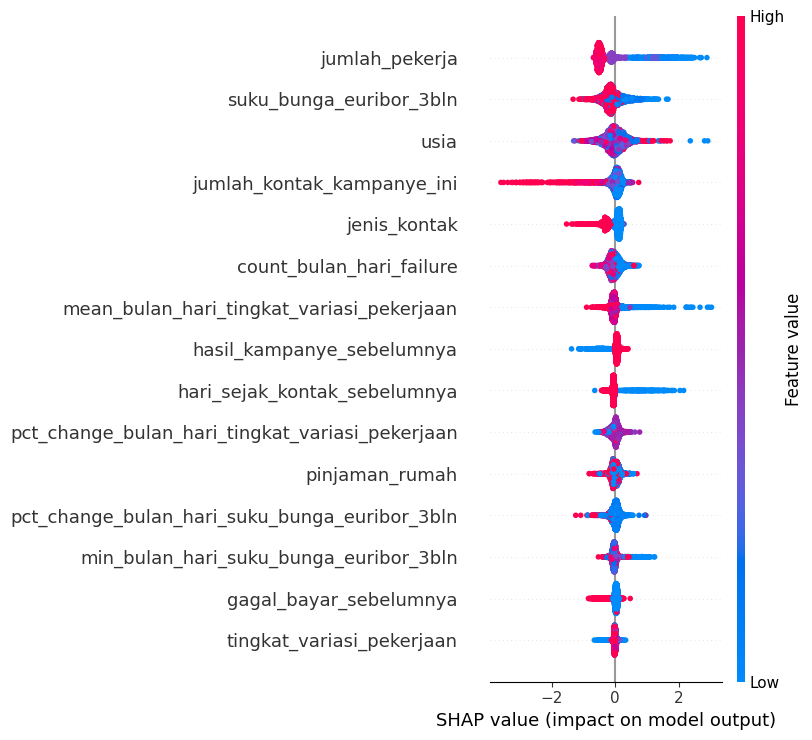

['jumlah_pekerja', 'suku_bunga_euribor_3bln', 'usia', 'jumlah_kontak_kampanye_ini', 'jenis_kontak', 'count_bulan_hari_failure', 'mean_bulan_hari_tingkat_variasi_pekerjaan', 'hasil_kampanye_sebelumnya', 'hari_sejak_kontak_sebelumnya', 'pct_change_bulan_hari_tingkat_variasi_pekerjaan', 'pinjaman_rumah', 'pct_change_bulan_hari_suku_bunga_euribor_3bln', 'min_bulan_hari_suku_bunga_euribor_3bln', 'gagal_bayar_sebelumnya', 'tingkat_variasi_pekerjaan']


In [74]:
plot_shap(xgb)

## LGB

In [75]:
lgb = LGBMClassifier(verbose=0, random_state=seed)

lgb.fit(X_train, y_train)

train(lgb)

roc_auc_score(y_test, lgb.predict_proba(X_test)[:, 1])

CV Scores: [0.78730587 0.78972192 0.77583199 0.79875907 0.79591334 0.79614444
 0.78578884 0.80619727 0.78664855 0.79118019]
Mean CV Score: 0.7913491472095204
Std Deviation: 0.007949968016653777


0.7939517482672231

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


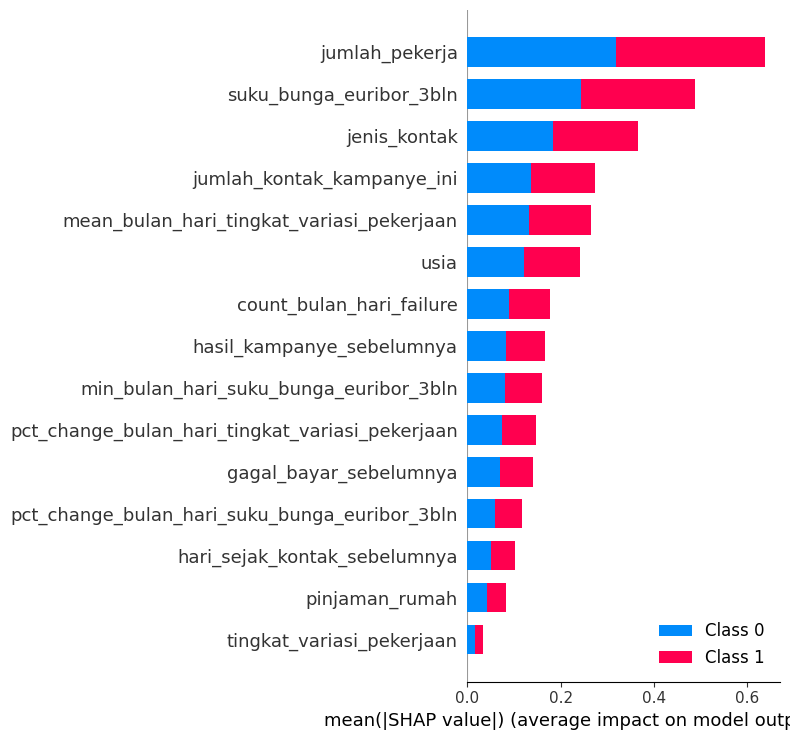

['jenis_kontak', 'usia', 'jumlah_pekerja', 'count_bulan_hari_failure', 'pinjaman_rumah', 'pct_change_bulan_hari_suku_bunga_euribor_3bln', 'jumlah_kontak_kampanye_ini', 'gagal_bayar_sebelumnya', 'tingkat_variasi_pekerjaan', 'mean_bulan_hari_tingkat_variasi_pekerjaan', 'pct_change_bulan_hari_tingkat_variasi_pekerjaan', 'min_bulan_hari_suku_bunga_euribor_3bln', 'hasil_kampanye_sebelumnya', 'hari_sejak_kontak_sebelumnya', 'suku_bunga_euribor_3bln']


In [76]:
plot_shap(lgb)

# Model Tuning / Hyperparameter Optimization

## XGB Optuna

In [77]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective_xgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1, 10),
        'random_state': seed
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train)

    pred_proba = model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, pred_proba)

    # print(f'[TRIAL {trial.number}] AUC: {auc:.4f} with {params}')
    return auc

In [78]:
study_xgb = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=seed))
study_xgb.optimize(objective_xgb, n_trials=300, show_progress_bar=True)

print(f'Best AUC: {study_xgb.best_value}')
print(f'Best Params: {study_xgb.best_params}')

  0%|          | 0/300 [00:00<?, ?it/s]

Best AUC: 0.8044887172342616
Best Params: {'n_estimators': 175, 'max_depth': 10, 'learning_rate': 0.01112956944861794, 'subsample': 0.7654464356689666, 'colsample_bytree': 0.9749700913203802, 'min_child_weight': 6, 'gamma': 2.5385628916336453, 'reg_alpha': 1.6743600408314292, 'reg_lambda': 5.631311343367793, 'colsample_bylevel': 0.6589234018754703, 'colsample_bynode': 0.7402845916006487, 'scale_pos_weight': 7.354570861874415}


In [79]:
best_model_xgb = XGBClassifier(**study_xgb.best_params, random_state=seed)

best_model_xgb.fit(X_train, y_train)

train(best_model_xgb)

roc_auc_score(y_test, best_model_xgb.predict_proba(X_test)[:, 1])

CV Scores: [0.78690915 0.80139792 0.78183357 0.79713552 0.80634834 0.80142749
 0.7973114  0.82031501 0.79148972 0.78023423]
Mean CV Score: 0.7964402355277074
Std Deviation: 0.01144643090095717


0.8044887172342616

## LGB Optuna

In [80]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective_lgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "num_leaves": trial.suggest_int("num_leaves", 8, 256),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),

        'random_state': seed
    }

    model = LGBMClassifier(**params, verbose=-1)
    model.fit(X_train, y_train)

    pred_proba = model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, pred_proba)

    # print(f'[TRIAL {trial.number}] AUC: {auc:.4f} with {params}')
    return auc

In [81]:
study_lgb = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=seed))
study_lgb.optimize(objective_lgb, n_trials=150, show_progress_bar=True)

print(f'Best AUC: {study_lgb.best_value}')
print(f'Best Params: {study_lgb.best_params}')

  0%|          | 0/150 [00:00<?, ?it/s]

Best AUC: 0.8026790771518286
Best Params: {'n_estimators': 848, 'learning_rate': 0.0028602631482163425, 'max_depth': 8, 'num_leaves': 138, 'subsample': 0.7168520356038246, 'colsample_bytree': 0.6112542793510216, 'min_child_samples': 68, 'min_split_gain': 0.09918841460400762, 'reg_alpha': 0.3008162227921869, 'reg_lambda': 1.008188468807333}


In [82]:
best_model_lgb = LGBMClassifier(**study_lgb.best_params, random_state=seed, verbose=-1)

best_model_lgb.fit(X_train, y_train)

train(best_model_lgb)

roc_auc_score(y_test, best_model_lgb.predict_proba(X_test)[:, 1])

CV Scores: [0.79002181 0.8040819  0.78173956 0.80143459 0.80838007 0.80878
 0.79559293 0.82046789 0.79514561 0.78489799]
Mean CV Score: 0.7990542338439258
Std Deviation: 0.011314105788255079


0.8026790771518286

## Deep Learning (Tensorflow)

In [83]:
# def create_model(input_dim):
#     model = tf.keras.Sequential([
#         tf.keras.layers.Input(shape=(input_dim,)),
#         tf.keras.layers.Dense(256, activation='swish'),
#         tf.keras.layers.Dropout(0.2),
#         tf.keras.layers.Dense(128, activation='swish'),
#         tf.keras.layers.Dropout(0.1),
#         tf.keras.layers.Dense(128, activation='swish'),
#         tf.keras.layers.Dropout(0.1),
#         tf.keras.layers.Dense(256, activation='swish'),
#         tf.keras.layers.Dropout(0.2),
#         tf.keras.layers.Dense(128, activation='swish'),
#         tf.keras.layers.Dropout(0.1),
#         tf.keras.layers.Dense(128, activation='swish'),
#         tf.keras.layers.Dropout(0.1),
#         tf.keras.layers.Dense(1, activation='sigmoid')
#     ])
    
#     model.compile(optimizer='adam',
#                   loss='binary_crossentropy',
#                   metrics=['AUC'])
    
#     return model

In [84]:
# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
# roc_aucs = []

# for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
#     print(f"Fold {fold}")
#     tf.keras.backend.clear_session()
    
#     X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

#     model = create_model(X.shape[1])

#     model.fit(X_train, y_train,
#               epochs=15,
#               batch_size=32,
#               verbose=0)

#     y_pred_prob = model.predict(X_val).ravel()
#     roc_auc = roc_auc_score(y_val, y_pred_prob)
#     roc_aucs.append(roc_auc)
#     print(f"ROC AUC for fold {fold}: {roc_auc:.4f}\n")

# print("\nCross-validation ROC AUC scores:", [f"{auc:.4f}" for auc in roc_aucs])
# print(f"Average ROC AUC: {np.mean(roc_aucs):.4f} ± {np.std(roc_aucs):.4f}")

## TFDF

In [85]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["YDF_NO_LOGS"] = "1"

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
roc_aucs = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
    print(f"Fold {fold}")
    tf.keras.backend.clear_session()
    
    Xcv_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    ycv_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    Xcv_train['target'] = ycv_train
    X_val['target'] = y_val
    
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(Xcv_train, label="target")
    val_ds = tfdf.keras.pd_dataframe_to_tf_dataset(X_val, label="target")

    model = tfdf.keras.GradientBoostedTreesModel(task=tfdf.keras.Task.CLASSIFICATION, verbose=0)

    model.fit(train_ds)

    y_pred_prob = model.predict(val_ds).ravel()
    roc_auc = roc_auc_score(y_val, y_pred_prob)
    roc_aucs.append(roc_auc)
    print(f"ROC AUC for fold {fold}: {roc_auc:.4f}\n")

Fold 0



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2025-06-22 12:37:26.626704: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1750595850.779400   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595850.779478   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595850.779492   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type:

3/3 [==============================] - 0s 7ms/step
ROC AUC for fold 0: 0.7909

Fold 1



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
I0000 00:00:1750595854.212371   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595854.212413   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595854.212425   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
   

3/3 [==============================] - 0s 6ms/step
ROC AUC for fold 1: 0.7998

Fold 2



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
I0000 00:00:1750595856.474762   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595856.474806   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595856.474821   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
   

3/3 [==============================] - 0s 8ms/step
ROC AUC for fold 2: 0.7740

Fold 3



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
I0000 00:00:1750595859.155036   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595859.155084   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595859.155101   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
   

3/3 [==============================] - 0s 10ms/step
ROC AUC for fold 3: 0.7996

Fold 4



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
I0000 00:00:1750595862.026242   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595862.026287   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595862.026305   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
   

3/3 [==============================] - 0s 7ms/step
ROC AUC for fold 4: 0.7981

Fold 5



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
I0000 00:00:1750595864.970757   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595864.970804   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595864.970816   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
   

3/3 [==============================] - 0s 7ms/step
ROC AUC for fold 5: 0.8038

Fold 6



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
I0000 00:00:1750595867.427144   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595867.427189   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595867.427207   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
   

3/3 [==============================] - 0s 7ms/step
ROC AUC for fold 6: 0.7957

Fold 7



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
I0000 00:00:1750595870.240008   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595870.240054   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595870.240067   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
   

3/3 [==============================] - 0s 7ms/step
ROC AUC for fold 7: 0.8143

Fold 8



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
I0000 00:00:1750595872.624998   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595872.625045   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595872.625058   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
   

3/3 [==============================] - 0s 7ms/step
ROC AUC for fold 8: 0.7893

Fold 9



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
I0000 00:00:1750595875.240256   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595875.240301   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595875.240338   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
   

3/3 [==============================] - 0s 7ms/step
ROC AUC for fold 9: 0.7890



In [86]:
print("\nCross-validation ROC AUC scores:", [f"{auc:.4f}" for auc in roc_aucs])
print(f"Average ROC AUC: {np.mean(roc_aucs):.4f} ± {np.std(roc_aucs):.4f}")


Cross-validation ROC AUC scores: ['0.7909', '0.7998', '0.7740', '0.7996', '0.7981', '0.8038', '0.7957', '0.8143', '0.7893', '0.7890']
Average ROC AUC: 0.7955 ± 0.0101


In [87]:
X_train['target'] = y_train
X_test['target'] = y_test

x_train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(X_train, label="target")
x_test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(X_test, label="target")

model = tfdf.keras.GradientBoostedTreesModel(task=tfdf.keras.Task.CLASSIFICATION, verbose=0)

model.fit(x_train_ds)

y_pred_prob = model.predict(x_test_ds).ravel()
roc_auc_score(y_test, y_pred_prob)

I0000 00:00:1750595877.842747   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595877.842788   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595877.842804   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750595877.842949   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750595877.842961   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750595877.845642   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 8ms/step


0.7961074493515005

In [88]:
def objective_tfdf(trial):
    num_trees = trial.suggest_int('num_trees', 100, 500)
    max_depth = trial.suggest_int('max_depth', 3, 12)
    min_examples = trial.suggest_int('min_examples', 2, 20)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    
    model = tfdf.keras.GradientBoostedTreesModel(
        num_trees=num_trees,
        max_depth=max_depth,
        min_examples=min_examples,
        subsample=subsample,
        early_stopping="LOSS_INCREASE"
    )
    
    model.fit(x_train_ds, verbose=0)
    
    y_pred_prob = model.predict(x_test_ds).ravel()
    
    return roc_auc_score(y_test, y_pred_prob)

In [89]:
study_tfdf = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=seed))
study_tfdf.optimize(objective_tfdf, n_trials=50, show_progress_bar=True)

  0%|          | 0/50 [00:00<?, ?it/s]

Use /tmp/tmp34dq5yik as temporary training directory


I0000 00:00:1750595879.960021   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595879.960066   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595879.960083   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750595879.960251   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750595879.960267   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750595879.962972   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 9ms/step
Use /tmp/tmpqvx6tmt6 as temporary training directory


I0000 00:00:1750595883.510086   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595883.510128   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595883.510140   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750595883.510244   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750595883.510252   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750595883.512807   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 8ms/step
Use /tmp/tmp1c_eby0z as temporary training directory


I0000 00:00:1750595886.769722   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595886.769763   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595886.769776   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750595886.769878   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750595886.769889   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750595886.772503   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 9ms/step
Use /tmp/tmpa4bg36dw as temporary training directory


I0000 00:00:1750595888.952878   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595888.952923   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595888.952936   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750595888.953038   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750595888.953046   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750595888.955756   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 9ms/step
Use /tmp/tmpgt0z42dr as temporary training directory


I0000 00:00:1750595892.635700   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595892.635742   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595892.635759   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750595892.635910   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750595892.635923   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750595892.638606   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 8ms/step
Use /tmp/tmp1homav8x as temporary training directory


I0000 00:00:1750595896.634564   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595896.634606   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595896.634619   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750595896.634719   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750595896.634727   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750595896.637703   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 9ms/step
Use /tmp/tmpni5q7uxw as temporary training directory


I0000 00:00:1750595900.639587   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595900.639627   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595900.639638   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750595900.639739   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750595900.639747   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750595900.642286   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 9ms/step
Use /tmp/tmphyly6mmf as temporary training directory


I0000 00:00:1750595903.191839   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595903.191883   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595903.191895   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750595903.191997   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750595903.192004   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750595903.194670   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 9ms/step
Use /tmp/tmp2wnxly9h as temporary training directory


I0000 00:00:1750595905.565471   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595905.565514   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595905.565527   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750595905.565630   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750595905.565637   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750595905.568261   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 9ms/step
Use /tmp/tmp3qpznq1k as temporary training directory


I0000 00:00:1750595907.760074   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595907.760117   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595907.760130   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750595907.760241   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750595907.760249   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750595907.762903   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 9ms/step
Use /tmp/tmponclfbr4 as temporary training directory


I0000 00:00:1750595910.754162   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595910.754206   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595910.754221   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750595910.754390   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750595910.754405   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750595910.757110   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 8ms/step
Use /tmp/tmp4299xsyr as temporary training directory


I0000 00:00:1750595912.764116   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595912.764184   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595912.764201   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750595912.764374   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750595912.764389   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750595912.767055   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 8ms/step
Use /tmp/tmpt9gehgti as temporary training directory


I0000 00:00:1750595915.844688   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595915.844737   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595915.844757   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750595915.844902   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750595915.844913   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750595915.847602   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 9ms/step
Use /tmp/tmpeps_zzmp as temporary training directory


I0000 00:00:1750595919.578676   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595919.578721   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595919.578734   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750595919.578837   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750595919.578845   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750595919.581429   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 8ms/step
Use /tmp/tmpnwwna2de as temporary training directory


I0000 00:00:1750595923.575659   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595923.575703   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595923.575716   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750595923.575818   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750595923.575826   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750595923.578433   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 1s 9ms/step
Use /tmp/tmp1a2eiqbx as temporary training directory


I0000 00:00:1750595928.346399   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595928.346443   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595928.346457   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750595928.346617   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750595928.346631   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750595928.349558   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 9ms/step
Use /tmp/tmpq_o8n6va as temporary training directory


I0000 00:00:1750595932.077434   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595932.077477   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595932.077489   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750595932.077594   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750595932.077602   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750595932.080172   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 9ms/step
Use /tmp/tmpw_dp276k as temporary training directory


I0000 00:00:1750595935.295863   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595935.295909   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595935.295925   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750595935.296082   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750595935.296098   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750595935.298799   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 8ms/step
Use /tmp/tmpeb0u87mj as temporary training directory


I0000 00:00:1750595938.716283   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595938.716346   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595938.716359   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750595938.716468   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750595938.716476   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750595938.719085   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 8ms/step
Use /tmp/tmpoatt2hy8 as temporary training directory


I0000 00:00:1750595941.613859   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595941.613903   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595941.613921   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750595941.614071   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750595941.614084   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750595941.616758   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 8ms/step
Use /tmp/tmpv3eaqf9r as temporary training directory


I0000 00:00:1750595944.167335   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595944.167427   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595944.167487   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750595944.167650   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750595944.167667   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750595944.170519   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 8ms/step
Use /tmp/tmp95jbpvfu as temporary training directory


I0000 00:00:1750595946.806372   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595946.806413   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595946.806425   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750595946.806527   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750595946.806534   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750595946.809333   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 10ms/step
Use /tmp/tmptju5jbh4 as temporary training directory


I0000 00:00:1750595949.679863   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595949.679908   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595949.679925   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750595949.680072   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750595949.680085   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750595949.682757   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 8ms/step
Use /tmp/tmpup7yu5m3 as temporary training directory


I0000 00:00:1750595952.627462   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595952.627504   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595952.627517   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750595952.627618   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750595952.627625   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750595952.630212   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 8ms/step
Use /tmp/tmpff6svyvh as temporary training directory


I0000 00:00:1750595956.245647   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595956.245689   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595956.245702   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750595956.245801   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750595956.245809   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750595956.248509   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 9ms/step
Use /tmp/tmpqj7r8x0y as temporary training directory


I0000 00:00:1750595959.593284   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595959.593341   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595959.593354   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750595959.593465   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750595959.593474   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750595959.596069   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 9ms/step
Use /tmp/tmpoz01yrfl as temporary training directory


I0000 00:00:1750595962.452225   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595962.452271   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595962.452284   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750595962.452423   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750595962.452431   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750595962.455108   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 9ms/step
Use /tmp/tmp5z1eg0co as temporary training directory


I0000 00:00:1750595965.091680   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595965.091724   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595965.091736   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750595965.091839   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750595965.091846   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750595965.094481   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 9ms/step
Use /tmp/tmprzzfw87z as temporary training directory


I0000 00:00:1750595968.278284   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595968.278420   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595968.278453   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750595968.278570   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750595968.278585   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750595968.281182   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 9ms/step
Use /tmp/tmpv99nntbm as temporary training directory


I0000 00:00:1750595970.774624   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595970.774668   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595970.774680   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750595970.774781   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750595970.774788   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750595970.777532   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 8ms/step
Use /tmp/tmpce_r6ea9 as temporary training directory


I0000 00:00:1750595973.213917   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595973.213965   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595973.213983   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750595973.214147   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750595973.214168   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750595973.216812   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 10ms/step
Use /tmp/tmp1nv6okbp as temporary training directory


I0000 00:00:1750595975.691703   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595975.691747   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595975.691761   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750595975.691868   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750595975.691875   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750595975.694486   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 9ms/step
Use /tmp/tmpivdmqdop as temporary training directory


I0000 00:00:1750595978.605972   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595978.606018   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595978.606036   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750595978.606198   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750595978.606211   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750595978.608859   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 8ms/step
Use /tmp/tmpx9rb1hg4 as temporary training directory


I0000 00:00:1750595982.095699   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595982.095741   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595982.095753   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750595982.095858   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750595982.095866   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750595982.098477   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 9ms/step
Use /tmp/tmpvhz1qeai as temporary training directory


I0000 00:00:1750595986.256750   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595986.256797   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595986.256810   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750595986.256921   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750595986.256928   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750595986.259628   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 8ms/step
Use /tmp/tmpyjf9jasw as temporary training directory


I0000 00:00:1750595989.972055   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595989.972107   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595989.972124   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750595989.972408   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750595989.972425   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750595989.976755   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 9ms/step
Use /tmp/tmpwbm_608x as temporary training directory


I0000 00:00:1750595994.039477   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595994.039522   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595994.039535   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750595994.039640   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750595994.039648   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750595994.042204   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 10ms/step
Use /tmp/tmpt9hh1mpn as temporary training directory


I0000 00:00:1750595996.590014   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595996.590063   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595996.590081   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750595996.590248   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750595996.590262   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750595996.593112   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 9ms/step
Use /tmp/tmpxz315bn_ as temporary training directory


I0000 00:00:1750595999.045286   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750595999.045346   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750595999.045363   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750595999.045528   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750595999.045542   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750595999.048159   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 8ms/step
Use /tmp/tmpcregtbgk as temporary training directory


I0000 00:00:1750596001.863963   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750596001.864012   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750596001.864032   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750596001.864181   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750596001.864194   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750596001.866833   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 10ms/step
Use /tmp/tmpcufajgz5 as temporary training directory


I0000 00:00:1750596005.884063   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750596005.884109   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750596005.884124   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750596005.884229   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750596005.884237   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750596005.886876   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 8ms/step
Use /tmp/tmpz5f5zgmy as temporary training directory


I0000 00:00:1750596008.327591   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750596008.327633   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750596008.327644   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750596008.327746   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750596008.327753   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750596008.330366   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 10ms/step
Use /tmp/tmpuqmtdxe3 as temporary training directory


I0000 00:00:1750596011.887162   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750596011.887205   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750596011.887217   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750596011.887367   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750596011.887382   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750596011.890155   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 9ms/step
Use /tmp/tmp75_jwuiv as temporary training directory


I0000 00:00:1750596015.070818   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750596015.070862   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750596015.070876   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750596015.071025   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750596015.071038   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750596015.073648   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 10ms/step
Use /tmp/tmpmhrs6c34 as temporary training directory


I0000 00:00:1750596018.360736   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750596018.360780   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750596018.360792   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750596018.360896   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750596018.360903   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750596018.363471   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 8ms/step
Use /tmp/tmpw0eo5c8t as temporary training directory


I0000 00:00:1750596020.880090   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750596020.880133   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750596020.880144   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750596020.880254   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750596020.880261   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750596020.882860   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 9ms/step
Use /tmp/tmpvsc7v_rx as temporary training directory


I0000 00:00:1750596023.777669   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750596023.777710   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750596023.777726   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750596023.777874   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750596023.777887   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750596023.780520   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 9ms/step
Use /tmp/tmp5zbm345l as temporary training directory


I0000 00:00:1750596027.053498   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750596027.053540   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750596027.053555   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750596027.053707   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750596027.053720   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750596027.056383   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 8ms/step
Use /tmp/tmp_12nzlmr as temporary training directory


I0000 00:00:1750596029.513436   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750596029.513479   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750596029.513492   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750596029.513596   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750596029.513604   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750596029.516361   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 9ms/step
Use /tmp/tmp9ubuvbpa as temporary training directory


I0000 00:00:1750596031.928026   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750596031.928070   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750596031.928083   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750596031.928191   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750596031.928199   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750596031.930756   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 8ms/step


In [90]:
print("Best trial:")
print(study_tfdf.best_trial)
print("Best params:")
print(study_tfdf.best_params)

Best trial:
FrozenTrial(number=44, state=1, values=[0.808515501884973], datetime_start=datetime.datetime(2025, 6, 22, 12, 40, 17, 757352), datetime_complete=datetime.datetime(2025, 6, 22, 12, 40, 20, 305835), params={'num_trees': 383, 'max_depth': 8, 'min_examples': 15, 'subsample': 0.8774021872109069}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_trees': IntDistribution(high=500, log=False, low=100, step=1), 'max_depth': IntDistribution(high=12, log=False, low=3, step=1), 'min_examples': IntDistribution(high=20, log=False, low=2, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.6, step=None)}, trial_id=44, value=None)
Best params:
{'num_trees': 383, 'max_depth': 8, 'min_examples': 15, 'subsample': 0.8774021872109069}


In [91]:
best = study_tfdf.best_params

best_model_tfdf = tfdf.keras.GradientBoostedTreesModel(
    num_trees=best["num_trees"],
    max_depth=best["max_depth"],
    min_examples=best["min_examples"],
    subsample=best["subsample"],
    early_stopping="LOSS_INCREASE"
)

best_model_tfdf.fit(x_train_ds, verbose=0)

y_pred_prob = best_model_tfdf.predict(x_test_ds).ravel()

roc_auc_score(y_test, y_pred_prob)

Use /tmp/tmpwgwkxemq as temporary training directory


I0000 00:00:1750596034.908175   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750596034.908218   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750596034.908235   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750596034.908397   27611 kernel.cc:401] Number of batches: 19
I0000 00:00:1750596034.908411   27611 kernel.cc:402] Number of examples: 18332
I0000 00:00:1750596034.911051   27611 kernel.cc:802] Training dataset:
Number of records: 18332
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

5/5 [==============================] - 0s 10ms/step


0.808515501884973

In [92]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
roc_aucs = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
    print(f"Fold {fold}")
    tf.keras.backend.clear_session()
    
    Xcv_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    ycv_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    Xcv_train['target'] = ycv_train
    X_val['target'] = y_val
    
    train_cv_ds = tfdf.keras.pd_dataframe_to_tf_dataset(Xcv_train, label="target")
    val_cv_ds = tfdf.keras.pd_dataframe_to_tf_dataset(X_val, label="target")

    tfdf_model = tfdf.keras.GradientBoostedTreesModel(
        num_trees=best["num_trees"],
        max_depth=best["max_depth"],
        min_examples=best["min_examples"],
        subsample=best["subsample"],
        early_stopping="LOSS_INCREASE"
    )

    tfdf_model.fit(train_cv_ds)

    y_pred_prob = tfdf_model.predict(val_cv_ds).ravel()
    roc_auc = roc_auc_score(y_val, y_pred_prob)
    roc_aucs.append(roc_auc)
    print(f"ROC AUC for fold {fold}: {roc_auc:.4f}\n")

Fold 0
Use /tmp/tmp6o1n6j9r as temporary training directory
Reading training dataset...



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training dataset read in 0:00:00.639381. Found 20624 examples.
Training model...


I0000 00:00:1750596038.569998   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750596038.570047   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750596038.570066   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750596038.570188   27611 kernel.cc:401] Number of batches: 21
I0000 00:00:1750596038.570201   27611 kernel.cc:402] Number of examples: 20624
I0000 00:00:1750596038.573184   27611 kernel.cc:802] Training dataset:
Number of records: 20624
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

Model trained in 0:00:01.589764
Compiling model...


I0000 00:00:1750596040.113062   48302 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.537094
I0000 00:00:1750596040.120880   48302 kernel.cc:926] Export model in log directory: /tmp/tmp6o1n6j9r with prefix d292a6be5b5748e4
I0000 00:00:1750596040.123838   48302 kernel.cc:944] Save model in resources
I0000 00:00:1750596040.126812   27611 abstract_model.cc:914] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 0.537094

Accuracy: 0.901711  CI95[W][0 1]
ErrorRate: : 0.0982885


Confusion Table:
truth\prediction
      1   2
1  1790  37
2   164  54
Total: 2045


I0000 00:00:1750596040.150348   27611 decision_forest.cc:761] Model loaded with 26 root(s), 3292 node(s), and 15 input feature(s).
I0000 00:00:1750596040.150413   27611 abstract_model.cc:1404] Engine "GradientBoostedTreesOptPred" built


Model compiled.
3/3 [==============================] - 0s 6ms/step
ROC AUC for fold 0: 0.7883

Fold 1
Use /tmp/tmp8wwt6_8h as temporary training directory
Reading training dataset...



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training dataset read in 0:00:00.584867. Found 20624 examples.
Training model...


I0000 00:00:1750596041.818477   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750596041.818522   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750596041.818542   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750596041.818663   27611 kernel.cc:401] Number of batches: 21
I0000 00:00:1750596041.818677   27611 kernel.cc:402] Number of examples: 20624
I0000 00:00:1750596041.821688   27611 kernel.cc:802] Training dataset:
Number of records: 20624
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

Model trained in 0:00:01.572645
Compiling model...


I0000 00:00:1750596043.346211   48562 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.562634
I0000 00:00:1750596043.353725   48562 kernel.cc:926] Export model in log directory: /tmp/tmp8wwt6_8h with prefix a2fdcc00be91418d
I0000 00:00:1750596043.356826   48562 kernel.cc:944] Save model in resources
I0000 00:00:1750596043.359766   27611 abstract_model.cc:914] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 0.562634

Accuracy: 0.894866  CI95[W][0 1]
ErrorRate: : 0.105134


Confusion Table:
truth\prediction
      1   2
1  1792  29
2   186  38
Total: 2045


I0000 00:00:1750596043.382029   27611 decision_forest.cc:761] Model loaded with 26 root(s), 3316 node(s), and 15 input feature(s).


Model compiled.
3/3 [==============================] - 0s 7ms/step
ROC AUC for fold 1: 0.7965

Fold 2
Use /tmp/tmpsmz9bs5z as temporary training directory
Reading training dataset...



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training dataset read in 0:00:00.589856. Found 20624 examples.
Training model...


I0000 00:00:1750596045.057750   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750596045.057795   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750596045.057814   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750596045.057921   27611 kernel.cc:401] Number of batches: 21
I0000 00:00:1750596045.057930   27611 kernel.cc:402] Number of examples: 20624
I0000 00:00:1750596045.060894   27611 kernel.cc:802] Training dataset:
Number of records: 20624
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

Model trained in 0:00:01.544842
Compiling model...


I0000 00:00:1750596046.560934   48822 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.54519
I0000 00:00:1750596046.567501   48822 kernel.cc:926] Export model in log directory: /tmp/tmpsmz9bs5z with prefix c4292717b26248fd
I0000 00:00:1750596046.570116   48822 kernel.cc:944] Save model in resources
I0000 00:00:1750596046.573014   27611 abstract_model.cc:914] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 0.54519

Accuracy: 0.901222  CI95[W][0 1]
ErrorRate: : 0.0987775


Confusion Table:
truth\prediction
      1   2
1  1786  32
2   170  57
Total: 2045


I0000 00:00:1750596046.594171   27611 decision_forest.cc:761] Model loaded with 28 root(s), 3218 node(s), and 15 input feature(s).


Model compiled.
3/3 [==============================] - 0s 5ms/step
ROC AUC for fold 2: 0.7781

Fold 3
Use /tmp/tmp3hlkxr5q as temporary training directory
Reading training dataset...



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training dataset read in 0:00:00.609409. Found 20624 examples.
Training model...


I0000 00:00:1750596048.293274   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750596048.293338   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750596048.293358   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750596048.293514   27611 kernel.cc:401] Number of batches: 21
I0000 00:00:1750596048.293531   27611 kernel.cc:402] Number of examples: 20624
I0000 00:00:1750596048.296613   27611 kernel.cc:802] Training dataset:
Number of records: 20624
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

Model trained in 0:00:01.757537
Compiling model...


I0000 00:00:1750596050.002653   49090 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.566542
I0000 00:00:1750596050.010984   49090 kernel.cc:926] Export model in log directory: /tmp/tmp3hlkxr5q with prefix ef7c8288ae0344af
I0000 00:00:1750596050.014733   49090 kernel.cc:944] Save model in resources
I0000 00:00:1750596050.017751   27611 abstract_model.cc:914] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 0.566542

Accuracy: 0.891932  CI95[W][0 1]
ErrorRate: : 0.108068


Confusion Table:
truth\prediction
      1   2
1  1758  39
2   182  66
Total: 2045


I0000 00:00:1750596050.042162   27611 decision_forest.cc:761] Model loaded with 35 root(s), 4035 node(s), and 15 input feature(s).


Model compiled.
3/3 [==============================] - 0s 7ms/step
ROC AUC for fold 3: 0.8039

Fold 4
Use /tmp/tmpkuk13gdv as temporary training directory
Reading training dataset...



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training dataset read in 0:00:00.568538. Found 20624 examples.
Training model...


I0000 00:00:1750596051.721826   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750596051.721875   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750596051.721892   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750596051.722018   27611 kernel.cc:401] Number of batches: 21
I0000 00:00:1750596051.722033   27611 kernel.cc:402] Number of examples: 20624
I0000 00:00:1750596051.725021   27611 kernel.cc:802] Training dataset:
Number of records: 20624
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

Model trained in 0:00:02.387280
Compiling model...


I0000 00:00:1750596054.046148   49386 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.557349
I0000 00:00:1750596054.056640   49386 kernel.cc:926] Export model in log directory: /tmp/tmpkuk13gdv with prefix 9ce5e37504464c90
I0000 00:00:1750596054.061744   49386 kernel.cc:944] Save model in resources
I0000 00:00:1750596054.064849   27611 abstract_model.cc:914] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 0.557349

Accuracy: 0.900244  CI95[W][0 1]
ErrorRate: : 0.0997555


Confusion Table:
truth\prediction
      1   2
1  1780  37
2   167  61
Total: 2045


I0000 00:00:1750596054.100202   27611 decision_forest.cc:761] Model loaded with 58 root(s), 5880 node(s), and 15 input feature(s).
I0000 00:00:1750596054.100262   27611 abstract_model.cc:1404] Engine "GradientBoostedTreesOptPred" built


Model compiled.
3/3 [==============================] - 0s 8ms/step
ROC AUC for fold 4: 0.7977

Fold 5
Use /tmp/tmp1g2pn8gq as temporary training directory
Reading training dataset...



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training dataset read in 0:00:00.572881. Found 20624 examples.
Training model...


I0000 00:00:1750596055.832263   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750596055.832332   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750596055.832352   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750596055.832504   27611 kernel.cc:401] Number of batches: 21
I0000 00:00:1750596055.832528   27611 kernel.cc:402] Number of examples: 20624
I0000 00:00:1750596055.835851   27611 kernel.cc:802] Training dataset:
Number of records: 20624
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

Model trained in 0:00:01.566100
Compiling model...


I0000 00:00:1750596057.357508   49774 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.532396
I0000 00:00:1750596057.365194   49774 kernel.cc:926] Export model in log directory: /tmp/tmp1g2pn8gq with prefix 340ae14405904adb
I0000 00:00:1750596057.368034   49774 kernel.cc:944] Save model in resources
I0000 00:00:1750596057.370906   27611 abstract_model.cc:914] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 0.532396

Accuracy: 0.895844  CI95[W][0 1]
ErrorRate: : 0.104156


Confusion Table:
truth\prediction
      1   2
1  1777  44
2   169  55
Total: 2045


I0000 00:00:1750596057.389897   27611 decision_forest.cc:761] Model loaded with 25 root(s), 3011 node(s), and 15 input feature(s).


Model compiled.
3/3 [==============================] - 0s 6ms/step
ROC AUC for fold 5: 0.8023

Fold 6
Use /tmp/tmp2u178fvo as temporary training directory
Reading training dataset...



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training dataset read in 0:00:00.565229. Found 20625 examples.
Training model...


I0000 00:00:1750596059.038712   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750596059.038758   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750596059.038781   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750596059.038949   27611 kernel.cc:401] Number of batches: 21
I0000 00:00:1750596059.038969   27611 kernel.cc:402] Number of examples: 20625
I0000 00:00:1750596059.041981   27611 kernel.cc:802] Training dataset:
Number of records: 20625
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

Model trained in 0:00:01.751888
Compiling model...


I0000 00:00:1750596060.738454   50030 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.592796
I0000 00:00:1750596060.751246   50030 kernel.cc:926] Export model in log directory: /tmp/tmp2u178fvo with prefix c8ee70389c234f84
I0000 00:00:1750596060.754969   50030 kernel.cc:944] Save model in resources
I0000 00:00:1750596060.757953   27611 abstract_model.cc:914] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 0.592796

Accuracy: 0.889976  CI95[W][0 1]
ErrorRate: : 0.110024


Confusion Table:
truth\prediction
      1   2
1  1748  43
2   182  72
Total: 2045


I0000 00:00:1750596060.782083   27611 decision_forest.cc:761] Model loaded with 35 root(s), 4091 node(s), and 15 input feature(s).


Model compiled.
3/3 [==============================] - 0s 7ms/step
ROC AUC for fold 6: 0.7962

Fold 7
Use /tmp/tmpupvfaygf as temporary training directory
Reading training dataset...



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training dataset read in 0:00:00.577301. Found 20625 examples.
Training model...


I0000 00:00:1750596062.435361   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750596062.435406   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750596062.435428   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750596062.435597   27611 kernel.cc:401] Number of batches: 21
I0000 00:00:1750596062.435613   27611 kernel.cc:402] Number of examples: 20625
I0000 00:00:1750596062.438627   27611 kernel.cc:802] Training dataset:
Number of records: 20625
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

Model trained in 0:00:01.484338
Compiling model...


I0000 00:00:1750596063.881381   50326 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.57478
I0000 00:00:1750596063.888150   50326 kernel.cc:926] Export model in log directory: /tmp/tmpupvfaygf with prefix cbe5aa5cf024463e
I0000 00:00:1750596063.890762   50326 kernel.cc:944] Save model in resources
I0000 00:00:1750596063.893496   27611 abstract_model.cc:914] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 0.57478

Accuracy: 0.895355  CI95[W][0 1]
ErrorRate: : 0.104645


Confusion Table:
truth\prediction
      1   2
1  1782  30
2   184  49
Total: 2045


I0000 00:00:1750596063.912008   27611 decision_forest.cc:761] Model loaded with 22 root(s), 2854 node(s), and 15 input feature(s).


Model compiled.
3/3 [==============================] - 0s 7ms/step
ROC AUC for fold 7: 0.8166

Fold 8
Use /tmp/tmpjd98lmtw as temporary training directory
Reading training dataset...



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training dataset read in 0:00:00.564148. Found 20625 examples.
Training model...


I0000 00:00:1750596065.567811   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750596065.567859   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750596065.567878   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750596065.567987   27611 kernel.cc:401] Number of batches: 21
I0000 00:00:1750596065.567995   27611 kernel.cc:402] Number of examples: 20625
I0000 00:00:1750596065.570964   27611 kernel.cc:802] Training dataset:
Number of records: 20625
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

Model trained in 0:00:01.641969
Compiling model...


I0000 00:00:1750596067.167450   50570 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.577981
I0000 00:00:1750596067.174833   50570 kernel.cc:926] Export model in log directory: /tmp/tmpjd98lmtw with prefix d1aedd5e08e64390
I0000 00:00:1750596067.177874   50570 kernel.cc:944] Save model in resources
I0000 00:00:1750596067.180747   27611 abstract_model.cc:914] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 0.577981

Accuracy: 0.886553  CI95[W][0 1]
ErrorRate: : 0.113447


Confusion Table:
truth\prediction
      1   2
1  1744  34
2   198  69
Total: 2045


I0000 00:00:1750596067.201962   27611 decision_forest.cc:761] Model loaded with 29 root(s), 3417 node(s), and 15 input feature(s).
I0000 00:00:1750596067.202020   27611 abstract_model.cc:1404] Engine "GradientBoostedTreesOptPred" built


Model compiled.
3/3 [==============================] - 0s 5ms/step
ROC AUC for fold 8: 0.7965

Fold 9
Use /tmp/tmp94g8o0z5 as temporary training directory
Reading training dataset...



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training dataset read in 0:00:00.576625. Found 20625 examples.
Training model...


I0000 00:00:1750596068.850640   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750596068.850689   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750596068.850708   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750596068.850813   27611 kernel.cc:401] Number of batches: 21
I0000 00:00:1750596068.850822   27611 kernel.cc:402] Number of examples: 20625
I0000 00:00:1750596068.853693   27611 kernel.cc:802] Training dataset:
Number of records: 20625
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

Model trained in 0:00:01.968730
Compiling model...


I0000 00:00:1750596070.767082   50842 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.497678
I0000 00:00:1750596070.775939   50842 kernel.cc:926] Export model in log directory: /tmp/tmp94g8o0z5 with prefix a47324973bed4f9b
I0000 00:00:1750596070.779988   50842 kernel.cc:944] Save model in resources
I0000 00:00:1750596070.783049   27611 abstract_model.cc:914] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 0.497678

Accuracy: 0.910513  CI95[W][0 1]
ErrorRate: : 0.0894865


Confusion Table:
truth\prediction
      1   2
1  1805  38
2   145  57
Total: 2045


I0000 00:00:1750596070.810415   27611 decision_forest.cc:761] Model loaded with 43 root(s), 4719 node(s), and 15 input feature(s).


Model compiled.
3/3 [==============================] - 0s 7ms/step
ROC AUC for fold 9: 0.7844



In [93]:
print("\nCross-validation ROC AUC scores:", [f"{auc:.4f}" for auc in roc_aucs])
print(f"Average ROC AUC: {np.mean(roc_aucs):.4f} ± {np.std(roc_aucs):.4f}")


Cross-validation ROC AUC scores: ['0.7883', '0.7965', '0.7781', '0.8039', '0.7977', '0.8023', '0.7962', '0.8166', '0.7965', '0.7844']
Average ROC AUC: 0.7961 ± 0.0102


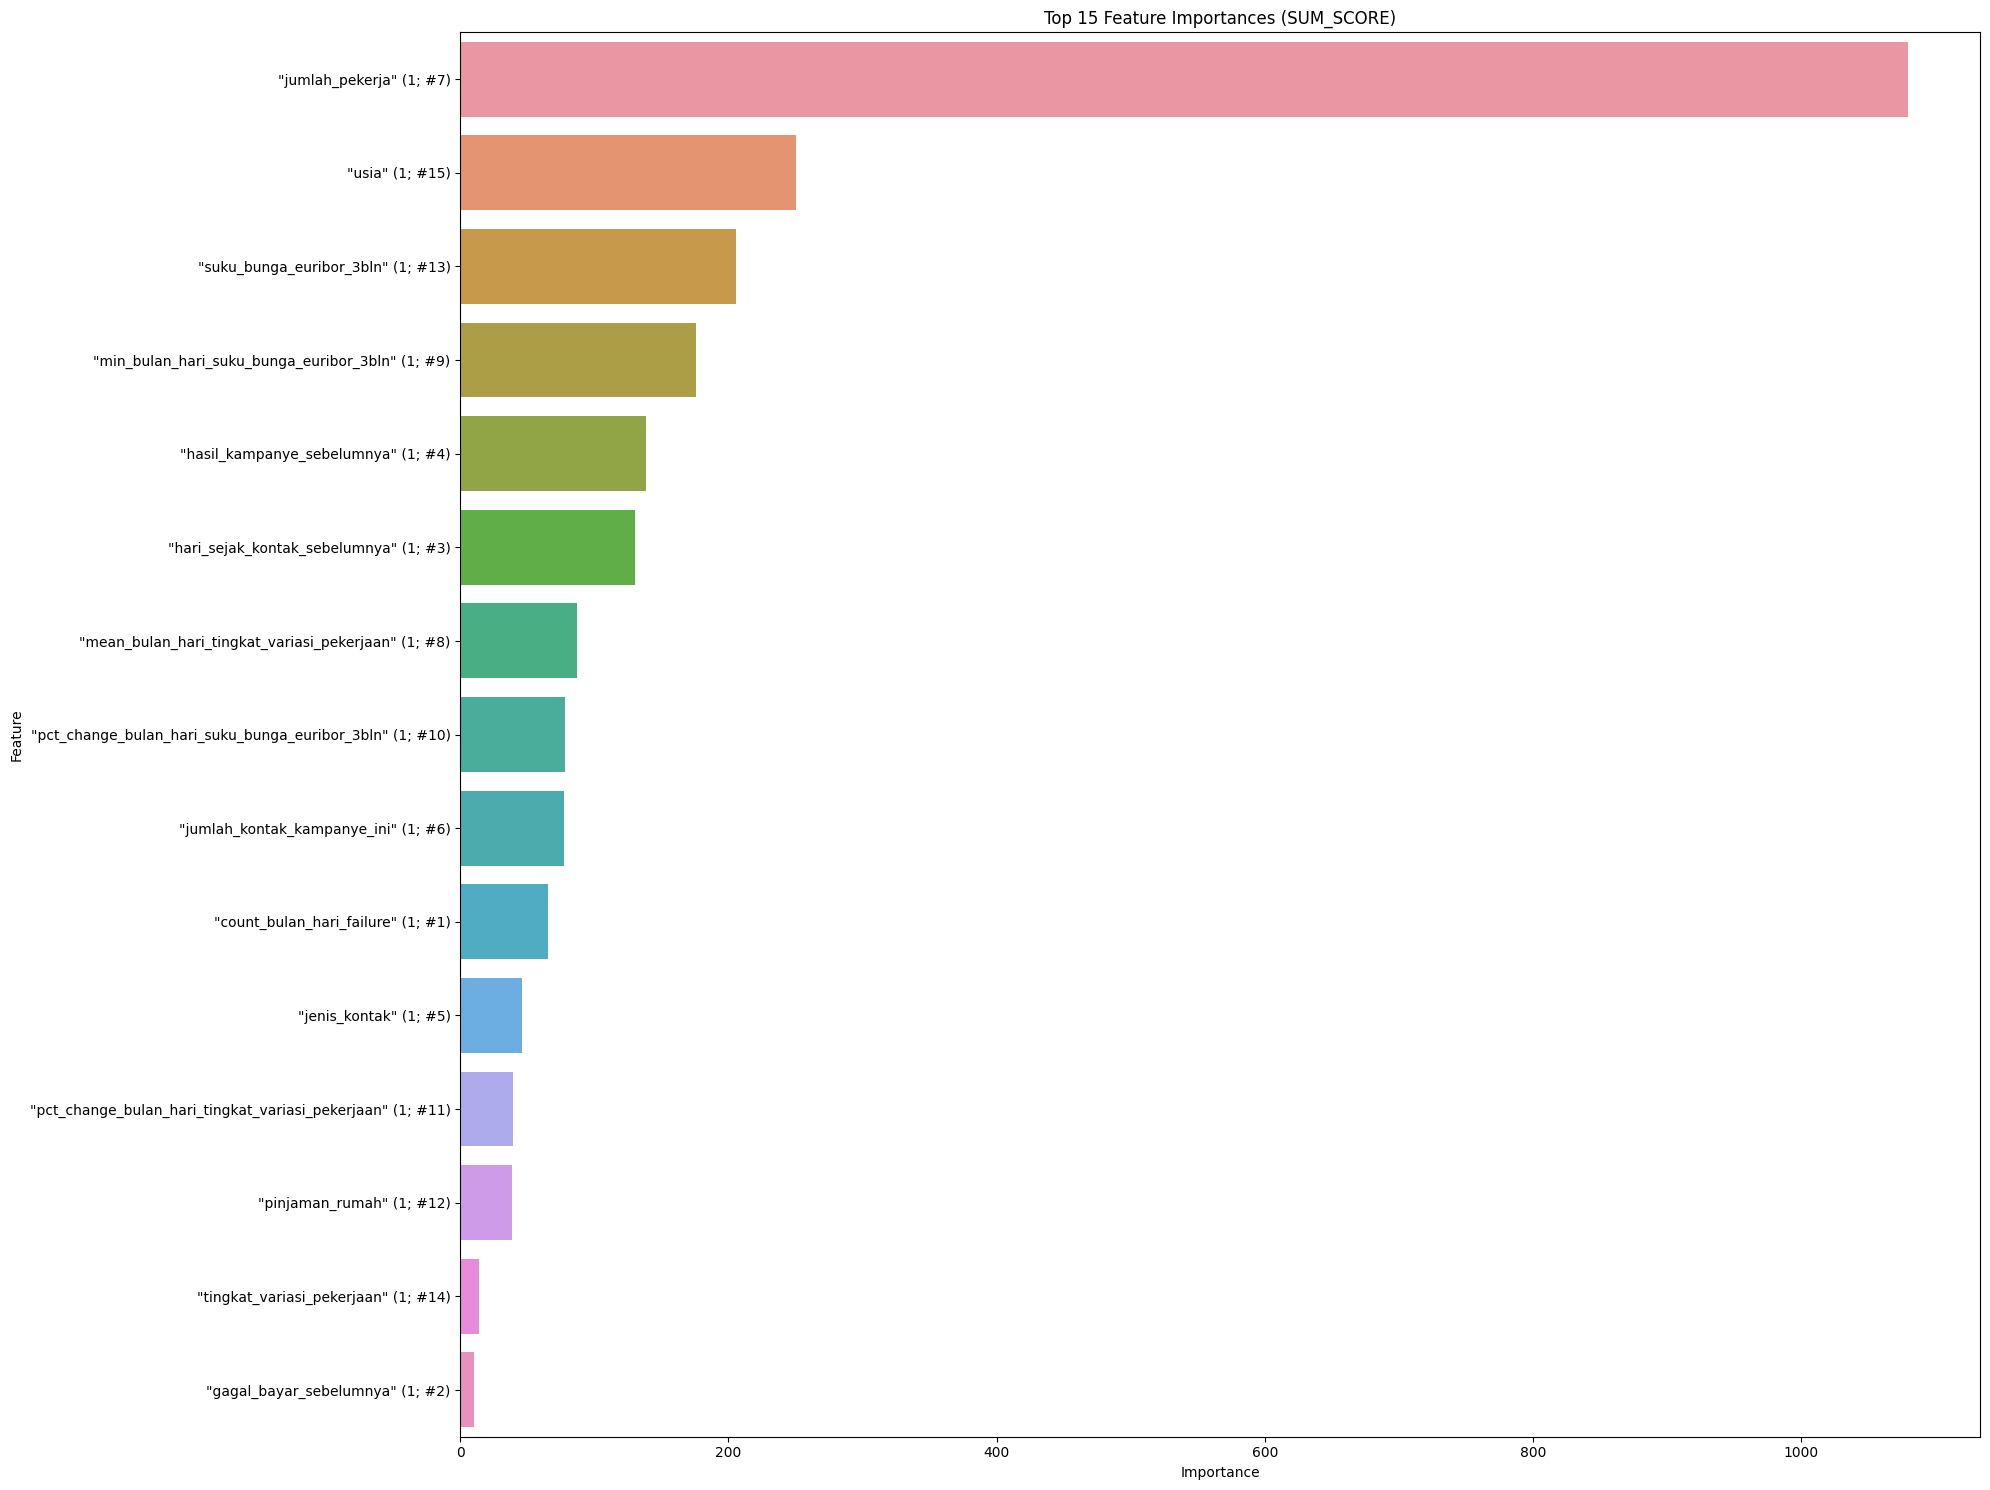

['jumlah_pekerja', 'usia', 'suku_bunga_euribor_3bln', 'min_bulan_hari_suku_bunga_euribor_3bln', 'hasil_kampanye_sebelumnya', 'hari_sejak_kontak_sebelumnya', 'mean_bulan_hari_tingkat_variasi_pekerjaan', 'pct_change_bulan_hari_suku_bunga_euribor_3bln', 'jumlah_kontak_kampanye_ini', 'count_bulan_hari_failure', 'jenis_kontak', 'pct_change_bulan_hari_tingkat_variasi_pekerjaan', 'pinjaman_rumah', 'tingkat_variasi_pekerjaan', 'gagal_bayar_sebelumnya']


In [94]:
inspector = best_model_tfdf.make_inspector()

importances = inspector.variable_importances()

importance_data = [
    (feature, score) for feature, score in importances["SUM_SCORE"]
]

importance_df = pd.DataFrame(importance_data, columns=["Feature", "Importance"])
importance_df.sort_values(by="Importance", ascending=False, inplace=True)

plt.figure(figsize=(20, 15))
sns.barplot(data=importance_df, x="Importance", y="Feature")
plt.title("Top 15 Feature Importances (SUM_SCORE)")
plt.tight_layout()
plt.show()

feature_names = [t[0] for t in importance_df.iloc[:, 0]]
print(feature_names[:15])

In [95]:
# import keras_tuner as kt

# def build_model(hp): 
#     input_dim = X_train.shape[1]
    
#     model = tf.keras.Sequential()
#     model.add(tf.keras.layers.Input(shape=(input_dim,)))

#     # Tune dense layer units and dropout rates
#     for i in range(hp.Int("num_blocks", 2, 6)):
#         model.add(tf.keras.layers.Dense(
#             hp.Int(f'units_{i}', min_value=64, max_value=512, step=64),
#             activation=hp.Choice("activation", ['swish', 'relu'])
#         ))
#         model.add(tf.keras.layers.Dropout(hp.Float(f'dropout_{i}', 0.1, 0.5, step=0.1)))

#     model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

#     # Tune learning rate
#     learning_rate = hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])
    
#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#         loss='binary_crossentropy',
#         metrics=['AUC']
#     )
    
#     return model

In [96]:
# tuner = kt.RandomSearch(
#     build_model,
#     objective='val_AUC',
#     max_trials=15,
#     executions_per_trial=1,
#     directory='kt_dir',
#     project_name='binary_classifier'
# )

In [97]:
# tuner.search(X, y,
#              epochs=15,
#              validation_split=0.2,
#              callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)],
#              verbose=1)

In [98]:
# best_hp = tuner.get_best_hyperparameters(1)[0]
# model = tuner.hypermodel.build(best_hp)
# model.fit(X, y, epochs=20, validation_split=0.2)

In [99]:
# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
# roc_aucs = []

# for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
#     print(f"Fold {fold}")
#     tf.keras.backend.clear_session()
    
#     X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

#     model = tuner.hypermodel.build(best_hp)

#     model.fit(X_train, y_train,
#               epochs=15,
#               batch_size=32,
#               verbose=0)

#     y_pred_prob = model.predict(X_val).ravel()
#     roc_auc = roc_auc_score(y_val, y_pred_prob)
#     roc_aucs.append(roc_auc)
#     print(f"ROC AUC for fold {fold}: {roc_auc:.4f}\n")

# print("\nCross-validation ROC AUC scores:", [f"{auc:.4f}" for auc in roc_aucs])
# print(f"Average ROC AUC: {np.mean(roc_aucs):.4f} ± {np.std(roc_aucs):.4f}")

# Main Inference

In [100]:
# model = best_model_lgb

# model.fit(X, y)

X['target'] = y

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(X, label="target")

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(validation)

model = tfdf.keras.GradientBoostedTreesModel(
    num_trees=best["num_trees"],
    max_depth=best["max_depth"],
    min_examples=best["min_examples"],
    subsample=best["subsample"],
    early_stopping="LOSS_INCREASE"
)

model.fit(train_ds)

Use /tmp/tmptebg41t0 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.607952. Found 22916 examples.
Training model...


I0000 00:00:1750596072.457373   27611 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750596072.457417   27611 kernel.cc:783] Collect training examples
I0000 00:00:1750596072.457441   27611 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750596072.457614   27611 kernel.cc:401] Number of batches: 23
I0000 00:00:1750596072.457634   27611 kernel.cc:402] Number of examples: 22916
I0000 00:00:1750596072.460989   27611 kernel.cc:802] Training dataset:
Number of records: 22916
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	1: "count_bulan_hari_failure"

Model trained in 0:00:01.910367
Compiling model...


I0000 00:00:1750596074.323646   51170 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.527805
I0000 00:00:1750596074.331449   51170 kernel.cc:926] Export model in log directory: /tmp/tmptebg41t0 with prefix a5468fa3275c4b1f
I0000 00:00:1750596074.334981   51170 kernel.cc:944] Save model in resources
I0000 00:00:1750596074.336973   27611 abstract_model.cc:914] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 0.527805

Accuracy: 0.905644  CI95[W][0 1]
ErrorRate: : 0.0943562


Confusion Table:
truth\prediction
      1   2
1  1982  30
2   184  72
Total: 2268


I0000 00:00:1750596074.361083   27611 decision_forest.cc:761] Model loaded with 34 root(s), 4212 node(s), and 15 input feature(s).


Model compiled.


In [101]:
inf_proba = model.predict(test_ds).ravel()

# inf_proba = model.predict_proba(test)[:, 1]

inf_proba = pd.Series(inf_proba)

inf_proba.head(10)

6/6 [==============================] - 0s 9ms/step


0    0.065593
1    0.036269
2    0.035016
3    0.036683
4    0.051690
5    0.030086
6    0.051124
7    0.063276
8    0.589994
9    0.065405
dtype: float32

# Submission

In [102]:
submission = pd.DataFrame({
    'customer_number': customer_number,
    'berlangganan_deposito': inf_proba
})

submission.head(15)

,customer_number,berlangganan_deposito
0,445420,0.065593
1,585604,0.036269
2,888824,0.035016
3,816820,0.036683
4,542716,0.051690
5,937852,0.030086
6,434084,0.051124
7,230861,0.063276
8,159684,0.589994
9,274159,0.065405


In [103]:
submission.to_csv('SUBMISSION.csv', index=False)

# Import Model

In [107]:
with open('tfdf.pkl','wb') as f:
    pickle.dump(model,f)